In [19]:
import os
import os.path
import glob
import time

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold                                                                                                                       
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
import matplotlib.pyplot as plt
import matplotlib.cm as colormap


import numpy as np
np.random.seed(1)

from keras.preprocessing.image import img_to_array
from keras.utils import np_utils
from keras.preprocessing import image
from keras.applications.resnet50 import ResNet50
from keras.applications.imagenet_utils import preprocess_input
from keras.applications.imagenet_utils import _obtain_input_shape
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Sequential,Model
from keras.layers import Input,Flatten,Dense,Dropout,GlobalAveragePooling2D,Conv2D,MaxPooling2D

In [2]:
imagedir = "Datasets/malimg_paper_dataset_imgs"

In [3]:
cur_dir = os.getcwd()
os.chdir(imagedir)  # the parent folder with sub-folders

# Get number of samples per family
list_fams = sorted(os.listdir(os.getcwd()), key=str.lower)  # vector of strings with family names
no_imgs = []  # No. of samples per family
for i in range(len(list_fams)):
    os.chdir(list_fams[i])
    len1 = len(glob.glob('*.png'))  # assuming the images are stored as 'png'
    no_imgs.append(len1)
    os.chdir('..')
num_samples = np.sum(no_imgs)  # total number of all samples

# Compute the labels
y = np.zeros(num_samples)
pos = 0
label = 0
for i in no_imgs:
    print ("Label:%2d\tFamily: %15s\tNumber of images: %d" % (label, list_fams[label], i))
    for j in range(i):
        y[pos] = label
        pos += 1
    label += 1
num_classes = label

# Compute the features
width, height,channels = (224,224,3)
X = np.zeros((num_samples, width, height, channels))
cnt = 0
list_paths = [] # List of image paths
print("Processing images ...")
for i in range(len(list_fams)):
    for img_file in glob.glob(list_fams[i]+'/*.png'):
        #print("[%d] Processing image: %s" % (cnt, img_file))
        list_paths.append(os.path.join(os.getcwd(),img_file))
        img = image.load_img(img_file, target_size=(224, 224))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        X[cnt] = x
        cnt += 1
print("Images processed: %d" %(cnt))

os.chdir(cur_dir)

Label: 0	Family:       Adialer.C	Number of images: 122
Label: 1	Family:       Agent.FYI	Number of images: 116
Label: 2	Family:       Allaple.A	Number of images: 2949
Label: 3	Family:       Allaple.L	Number of images: 1591
Label: 4	Family:   Alueron.gen!J	Number of images: 198
Label: 5	Family:       Autorun.K	Number of images: 106
Label: 6	Family:     C2LOP.gen!g	Number of images: 200
Label: 7	Family:         C2LOP.P	Number of images: 146
Label: 8	Family:  Dialplatform.B	Number of images: 177
Label: 9	Family:       Dontovo.A	Number of images: 162
Label:10	Family:        Fakerean	Number of images: 381
Label:11	Family:   Instantaccess	Number of images: 431
Label:12	Family:      Lolyda.AA1	Number of images: 213
Label:13	Family:      Lolyda.AA2	Number of images: 184
Label:14	Family:      Lolyda.AA3	Number of images: 123
Label:15	Family:       Lolyda.AT	Number of images: 159
Label:16	Family:     Malex.gen!J	Number of images: 136
Label:17	Family:   Obfuscator.AD	Number of images: 142
Label:18

In [4]:
X.shape

(9339, 224, 224, 3)

In [5]:
# Encoding classes (y) into integers (y_encoded) and then generating one-hot-encoding (Y)
encoder = LabelEncoder()
encoder.fit(y)
y_encoded = encoder.transform(y)
Y = np_utils.to_categorical(y_encoded)

In [6]:
# Creating base_model (ResNet50 notop)
image_shape = (224, 224, 3)                                                                                                                                                                                                                                                                                            
base_model = ResNet50(weights='imagenet', input_shape=image_shape, include_top=False, pooling='avg')

In [7]:
filename = 'malimg-resnet50features.npy'
if os.path.exists(filename):
    print("Loading ResNet50 extracted features from %s ..." %(filename))
    resnet50features = np.load(filename)
else:
    print("Extracting features from ResNet50 layers ...")
    resnet50features = base_model.predict(X)
    print("Saving ResNet50 extracted features into %s ..." %(filename))
    np.save(filename, resnet50features)

Loading ResNet50 extracted features from malimg-resnet50features.npy ...


In [8]:
resnet50features.shape

(9339, 1, 1, 2048)

In [9]:
# Create stratified k-fold subsets                                                                                                                                        
kfold = 10  # no. of folds                                                                 
skf = StratifiedKFold(kfold, shuffle=True,random_state=1)
skfind = [None] * kfold  # skfind[i][0] -> train indices, skfind[i][1] -> test indices
cnt = 0                                              
for index in skf.split(X, y):         
    skfind[cnt] = index                                                 
    cnt += 1 

In [10]:
# Training top_model and saving min training loss weights
num_epochs=2000
history = []
conf_mat = np.zeros((len(list_fams),len(list_fams))) # Initializing the Confusion Matrix
early_stopping = EarlyStopping(verbose=1, patience=20, monitor='val_loss')
checkpointer = ModelCheckpoint(filepath='paper-malimg-resnet50-avgpool-Adam-2000epochs-earlystop.h5', monitor='loss', verbose=0, save_best_only=True, save_weights_only=True, mode='min')
callbacks_list = [early_stopping, checkpointer]
for i in range(kfold):
    train_indices = skfind[i][0]
    test_indices = skfind[i][1]
    X_train = resnet50features[train_indices]
    Y_train = Y[train_indices]
    X_test = resnet50features[test_indices]
    Y_test = Y[test_indices]
    y_test = y[test_indices]

    top_input = Input(shape=resnet50features.shape[1:])
    x = GlobalAveragePooling2D(name='avg_pool')(top_input)
    predict = Dense(num_classes, activation='softmax', name='predictions')(x)
    top_model = Model(input=top_input, output=predict)                            
    top_model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    start = time.time()
    h = top_model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=num_epochs, batch_size=X_train.shape[0], verbose=1, callbacks=callbacks_list)
    end = time.time()
    history.append(h)
    
    y_prob = top_model.predict(X_test, verbose=0)  # Testing
    y_pred = np.argmax(y_prob, axis=1)
    print("[%d] Test acurracy: %.4f (%.4f s)" %(i,accuracy_score(y_test,y_pred),end-start))
    
    print(classification_report(y_test, y_pred, target_names=list_fams))
    
    cm = confusion_matrix(y_test,y_pred)  # Compute confusion matrix for this fold
    conf_mat = conf_mat + cm  # Compute global confusion matrix

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:20: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("pr..., inputs=Tensor("in...)`


Train on 8394 samples, validate on 945 samples
Epoch 1/2000
8394/8394 [==============================] - 2s - loss: 4.8370 - acc: 0.0394 - val_loss: 3.9053 - val_acc: 0.0370
Epoch 2/2000
8394/8394 [==============================] - 1s - loss: 3.9100 - acc: 0.0367 - val_loss: 3.2292 - val_acc: 0.2127
Epoch 3/2000
8394/8394 [==============================] - 0s - loss: 3.2311 - acc: 0.2086 - val_loss: 2.7092 - val_acc: 0.2392
Epoch 4/2000
8394/8394 [==============================] - 0s - loss: 2.7074 - acc: 0.2399 - val_loss: 2.3166 - val_acc: 0.2444
Epoch 5/2000
8394/8394 [==============================] - 0s - loss: 2.3104 - acc: 0.2415 - val_loss: 2.0595 - val_acc: 0.4698
Epoch 6/2000
8394/8394 [==============================] - 1s - loss: 2.0488 - acc: 0.4532 - val_loss: 1.9025 - val_acc: 0.4233
Epoch 7/2000
8394/8394 [==============================] - 0s - loss: 1.8882 - acc: 0.4116 - val_loss: 1.8053 - val_acc: 0.3989
Epoch 8/2000
8394/8394 [==============================] - 1s - l

8394/8394 [==============================] - 0s - loss: 0.1351 - acc: 0.9632 - val_loss: 0.1614 - val_acc: 0.9524
Epoch 128/2000
8394/8394 [==============================] - 0s - loss: 0.1343 - acc: 0.9633 - val_loss: 0.1607 - val_acc: 0.9524
Epoch 129/2000
8394/8394 [==============================] - 1s - loss: 0.1336 - acc: 0.9634 - val_loss: 0.1600 - val_acc: 0.9524
Epoch 130/2000
8394/8394 [==============================] - 0s - loss: 0.1328 - acc: 0.9635 - val_loss: 0.1592 - val_acc: 0.9534
Epoch 131/2000
8394/8394 [==============================] - 0s - loss: 0.1321 - acc: 0.9637 - val_loss: 0.1585 - val_acc: 0.9534
Epoch 132/2000
8394/8394 [==============================] - 1s - loss: 0.1313 - acc: 0.9638 - val_loss: 0.1579 - val_acc: 0.9534
Epoch 133/2000
8394/8394 [==============================] - 1s - loss: 0.1306 - acc: 0.9638 - val_loss: 0.1572 - val_acc: 0.9534
Epoch 134/2000
8394/8394 [==============================] - 0s - loss: 0.1299 - acc: 0.9639 - val_loss: 0.1565 -

8394/8394 [==============================] - 0s - loss: 0.0798 - acc: 0.9796 - val_loss: 0.1091 - val_acc: 0.9651
Epoch 254/2000
8394/8394 [==============================] - 0s - loss: 0.0796 - acc: 0.9796 - val_loss: 0.1089 - val_acc: 0.9651
Epoch 255/2000
8394/8394 [==============================] - 1s - loss: 0.0793 - acc: 0.9796 - val_loss: 0.1087 - val_acc: 0.9651
Epoch 256/2000
8394/8394 [==============================] - 0s - loss: 0.0790 - acc: 0.9796 - val_loss: 0.1084 - val_acc: 0.9651
Epoch 257/2000
8394/8394 [==============================] - 1s - loss: 0.0788 - acc: 0.9796 - val_loss: 0.1082 - val_acc: 0.9651
Epoch 258/2000
8394/8394 [==============================] - 0s - loss: 0.0785 - acc: 0.9796 - val_loss: 0.1079 - val_acc: 0.9651
Epoch 259/2000
8394/8394 [==============================] - 0s - loss: 0.0783 - acc: 0.9796 - val_loss: 0.1077 - val_acc: 0.9651
Epoch 260/2000
8394/8394 [==============================] - 0s - loss: 0.0780 - acc: 0.9796 - val_loss: 0.1075 -

8394/8394 [==============================] - 1s - loss: 0.0556 - acc: 0.9826 - val_loss: 0.0863 - val_acc: 0.9661
Epoch 380/2000
8394/8394 [==============================] - 1s - loss: 0.0555 - acc: 0.9826 - val_loss: 0.0862 - val_acc: 0.9661
Epoch 381/2000
8394/8394 [==============================] - 0s - loss: 0.0554 - acc: 0.9826 - val_loss: 0.0861 - val_acc: 0.9661
Epoch 382/2000
8394/8394 [==============================] - 0s - loss: 0.0552 - acc: 0.9826 - val_loss: 0.0859 - val_acc: 0.9661
Epoch 383/2000
8394/8394 [==============================] - 1s - loss: 0.0551 - acc: 0.9826 - val_loss: 0.0858 - val_acc: 0.9661
Epoch 384/2000
8394/8394 [==============================] - 0s - loss: 0.0549 - acc: 0.9826 - val_loss: 0.0857 - val_acc: 0.9661
Epoch 385/2000
8394/8394 [==============================] - 0s - loss: 0.0548 - acc: 0.9826 - val_loss: 0.0855 - val_acc: 0.9661
Epoch 386/2000
8394/8394 [==============================] - 1s - loss: 0.0546 - acc: 0.9826 - val_loss: 0.0854 -

8394/8394 [==============================] - 1s - loss: 0.0409 - acc: 0.9965 - val_loss: 0.0731 - val_acc: 0.9810
Epoch 506/2000
8394/8394 [==============================] - 0s - loss: 0.0409 - acc: 0.9965 - val_loss: 0.0730 - val_acc: 0.9810
Epoch 507/2000
8394/8394 [==============================] - 0s - loss: 0.0408 - acc: 0.9965 - val_loss: 0.0729 - val_acc: 0.9810
Epoch 508/2000
8394/8394 [==============================] - 1s - loss: 0.0407 - acc: 0.9965 - val_loss: 0.0728 - val_acc: 0.9810
Epoch 509/2000
8394/8394 [==============================] - 1s - loss: 0.0406 - acc: 0.9965 - val_loss: 0.0727 - val_acc: 0.9810
Epoch 510/2000
8394/8394 [==============================] - 0s - loss: 0.0405 - acc: 0.9965 - val_loss: 0.0727 - val_acc: 0.9810
Epoch 511/2000
8394/8394 [==============================] - 0s - loss: 0.0404 - acc: 0.9965 - val_loss: 0.0726 - val_acc: 0.9810
Epoch 512/2000
8394/8394 [==============================] - 0s - loss: 0.0403 - acc: 0.9965 - val_loss: 0.0725 -

8394/8394 [==============================] - 0s - loss: 0.0311 - acc: 0.9974 - val_loss: 0.0648 - val_acc: 0.9810
Epoch 632/2000
8394/8394 [==============================] - 0s - loss: 0.0310 - acc: 0.9974 - val_loss: 0.0647 - val_acc: 0.9810
Epoch 633/2000
8394/8394 [==============================] - 0s - loss: 0.0310 - acc: 0.9974 - val_loss: 0.0647 - val_acc: 0.9810
Epoch 634/2000
8394/8394 [==============================] - 0s - loss: 0.0309 - acc: 0.9974 - val_loss: 0.0646 - val_acc: 0.9810
Epoch 635/2000
8394/8394 [==============================] - 0s - loss: 0.0308 - acc: 0.9974 - val_loss: 0.0646 - val_acc: 0.9810
Epoch 636/2000
8394/8394 [==============================] - 0s - loss: 0.0308 - acc: 0.9974 - val_loss: 0.0645 - val_acc: 0.9810
Epoch 637/2000
8394/8394 [==============================] - 0s - loss: 0.0307 - acc: 0.9974 - val_loss: 0.0645 - val_acc: 0.9810
Epoch 638/2000
8394/8394 [==============================] - 1s - loss: 0.0307 - acc: 0.9974 - val_loss: 0.0644 -

8394/8394 [==============================] - 0s - loss: 0.0243 - acc: 0.9986 - val_loss: 0.0594 - val_acc: 0.9810
Epoch 758/2000
8394/8394 [==============================] - 0s - loss: 0.0242 - acc: 0.9986 - val_loss: 0.0593 - val_acc: 0.9810
Epoch 759/2000
8394/8394 [==============================] - 0s - loss: 0.0242 - acc: 0.9986 - val_loss: 0.0593 - val_acc: 0.9810
Epoch 760/2000
8394/8394 [==============================] - 0s - loss: 0.0241 - acc: 0.9986 - val_loss: 0.0593 - val_acc: 0.9810
Epoch 761/2000
8394/8394 [==============================] - 0s - loss: 0.0241 - acc: 0.9987 - val_loss: 0.0592 - val_acc: 0.9810
Epoch 762/2000
8394/8394 [==============================] - 1s - loss: 0.0240 - acc: 0.9987 - val_loss: 0.0592 - val_acc: 0.9810
Epoch 763/2000
8394/8394 [==============================] - 0s - loss: 0.0240 - acc: 0.9987 - val_loss: 0.0592 - val_acc: 0.9810
Epoch 764/2000
8394/8394 [==============================] - 0s - loss: 0.0240 - acc: 0.9987 - val_loss: 0.0591 -

8394/8394 [==============================] - 0s - loss: 0.0194 - acc: 0.9994 - val_loss: 0.0557 - val_acc: 0.9810
Epoch 884/2000
8394/8394 [==============================] - 0s - loss: 0.0194 - acc: 0.9994 - val_loss: 0.0557 - val_acc: 0.9810
Epoch 885/2000
8394/8394 [==============================] - 0s - loss: 0.0193 - acc: 0.9994 - val_loss: 0.0557 - val_acc: 0.9810
Epoch 886/2000
8394/8394 [==============================] - 0s - loss: 0.0193 - acc: 0.9994 - val_loss: 0.0557 - val_acc: 0.9810
Epoch 887/2000
8394/8394 [==============================] - 0s - loss: 0.0193 - acc: 0.9994 - val_loss: 0.0557 - val_acc: 0.9810
Epoch 888/2000
8394/8394 [==============================] - 0s - loss: 0.0192 - acc: 0.9994 - val_loss: 0.0556 - val_acc: 0.9810
Epoch 889/2000
8394/8394 [==============================] - 1s - loss: 0.0192 - acc: 0.9994 - val_loss: 0.0556 - val_acc: 0.9810
Epoch 890/2000
8394/8394 [==============================] - 0s - loss: 0.0192 - acc: 0.9994 - val_loss: 0.0556 -

8394/8394 [==============================] - 0s - loss: 0.0158 - acc: 0.9995 - val_loss: 0.0533 - val_acc: 0.9810
Epoch 1010/2000
8394/8394 [==============================] - 0s - loss: 0.0158 - acc: 0.9995 - val_loss: 0.0533 - val_acc: 0.9810
Epoch 1011/2000
8394/8394 [==============================] - 0s - loss: 0.0158 - acc: 0.9995 - val_loss: 0.0533 - val_acc: 0.9810
Epoch 1012/2000
8394/8394 [==============================] - 0s - loss: 0.0157 - acc: 0.9995 - val_loss: 0.0532 - val_acc: 0.9810
Epoch 1013/2000
8394/8394 [==============================] - 0s - loss: 0.0157 - acc: 0.9995 - val_loss: 0.0532 - val_acc: 0.9810
Epoch 1014/2000
8394/8394 [==============================] - 0s - loss: 0.0157 - acc: 0.9995 - val_loss: 0.0532 - val_acc: 0.9810
Epoch 1015/2000
8394/8394 [==============================] - 0s - loss: 0.0157 - acc: 0.9995 - val_loss: 0.0532 - val_acc: 0.9810
Epoch 1016/2000
8394/8394 [==============================] - 0s - loss: 0.0156 - acc: 0.9995 - val_loss: 0

8394/8394 [==============================] - 0s - loss: 0.0131 - acc: 0.9998 - val_loss: 0.0516 - val_acc: 0.9810
Epoch 1136/2000
8394/8394 [==============================] - 0s - loss: 0.0131 - acc: 0.9998 - val_loss: 0.0516 - val_acc: 0.9810
Epoch 1137/2000
8394/8394 [==============================] - 0s - loss: 0.0131 - acc: 0.9998 - val_loss: 0.0516 - val_acc: 0.9810
Epoch 1138/2000
8394/8394 [==============================] - 0s - loss: 0.0131 - acc: 0.9998 - val_loss: 0.0516 - val_acc: 0.9810
Epoch 1139/2000
8394/8394 [==============================] - 0s - loss: 0.0130 - acc: 0.9998 - val_loss: 0.0515 - val_acc: 0.9810
Epoch 1140/2000
8394/8394 [==============================] - 0s - loss: 0.0130 - acc: 0.9998 - val_loss: 0.0515 - val_acc: 0.9810
Epoch 1141/2000
8394/8394 [==============================] - 0s - loss: 0.0130 - acc: 0.9998 - val_loss: 0.0515 - val_acc: 0.9810
Epoch 1142/2000
8394/8394 [==============================] - 0s - loss: 0.0130 - acc: 0.9998 - val_loss: 0

8394/8394 [==============================] - 0s - loss: 0.0110 - acc: 0.9999 - val_loss: 0.0504 - val_acc: 0.9810
Epoch 1262/2000
8394/8394 [==============================] - 0s - loss: 0.0110 - acc: 0.9999 - val_loss: 0.0504 - val_acc: 0.9810
Epoch 1263/2000
8394/8394 [==============================] - 0s - loss: 0.0110 - acc: 0.9999 - val_loss: 0.0504 - val_acc: 0.9810
Epoch 1264/2000
8394/8394 [==============================] - 0s - loss: 0.0110 - acc: 0.9999 - val_loss: 0.0504 - val_acc: 0.9810
Epoch 1265/2000
8394/8394 [==============================] - 0s - loss: 0.0110 - acc: 0.9999 - val_loss: 0.0504 - val_acc: 0.9810
Epoch 1266/2000
8394/8394 [==============================] - 0s - loss: 0.0109 - acc: 0.9999 - val_loss: 0.0504 - val_acc: 0.9810
Epoch 1267/2000
8394/8394 [==============================] - 0s - loss: 0.0109 - acc: 0.9999 - val_loss: 0.0504 - val_acc: 0.9810
Epoch 1268/2000
8394/8394 [==============================] - 0s - loss: 0.0109 - acc: 0.9999 - val_loss: 0

8394/8394 [==============================] - 0s - loss: 0.0094 - acc: 0.9999 - val_loss: 0.0496 - val_acc: 0.9810
Epoch 1388/2000
8394/8394 [==============================] - 0s - loss: 0.0094 - acc: 0.9999 - val_loss: 0.0496 - val_acc: 0.9810
Epoch 1389/2000
8394/8394 [==============================] - 0s - loss: 0.0093 - acc: 0.9999 - val_loss: 0.0496 - val_acc: 0.9810
Epoch 1390/2000
8394/8394 [==============================] - 0s - loss: 0.0093 - acc: 0.9999 - val_loss: 0.0496 - val_acc: 0.9810
Epoch 1391/2000
8394/8394 [==============================] - 0s - loss: 0.0093 - acc: 0.9999 - val_loss: 0.0496 - val_acc: 0.9810
Epoch 1392/2000
8394/8394 [==============================] - 0s - loss: 0.0093 - acc: 0.9999 - val_loss: 0.0496 - val_acc: 0.9810
Epoch 1393/2000
8394/8394 [==============================] - 0s - loss: 0.0093 - acc: 0.9999 - val_loss: 0.0496 - val_acc: 0.9810
Epoch 1394/2000
8394/8394 [==============================] - 0s - loss: 0.0093 - acc: 0.9999 - val_loss: 0

8394/8394 [==============================] - 0s - loss: 0.0080 - acc: 0.9999 - val_loss: 0.0491 - val_acc: 0.9799
Epoch 1514/2000
8394/8394 [==============================] - 0s - loss: 0.0080 - acc: 0.9999 - val_loss: 0.0491 - val_acc: 0.9799
Epoch 1515/2000
8394/8394 [==============================] - 0s - loss: 0.0080 - acc: 0.9999 - val_loss: 0.0491 - val_acc: 0.9799
Epoch 1516/2000
8394/8394 [==============================] - 0s - loss: 0.0080 - acc: 0.9999 - val_loss: 0.0491 - val_acc: 0.9799
Epoch 1517/2000
8394/8394 [==============================] - 0s - loss: 0.0080 - acc: 0.9999 - val_loss: 0.0491 - val_acc: 0.9799
Epoch 1518/2000
8394/8394 [==============================] - 0s - loss: 0.0080 - acc: 0.9999 - val_loss: 0.0491 - val_acc: 0.9799
Epoch 1519/2000
8394/8394 [==============================] - 0s - loss: 0.0080 - acc: 0.9999 - val_loss: 0.0490 - val_acc: 0.9799
Epoch 1520/2000
8394/8394 [==============================] - 0s - loss: 0.0080 - acc: 0.9999 - val_loss: 0

8394/8394 [==============================] - 0s - loss: 0.0070 - acc: 0.9999 - val_loss: 0.0488 - val_acc: 0.9799
Epoch 1640/2000
8394/8394 [==============================] - 0s - loss: 0.0070 - acc: 0.9999 - val_loss: 0.0488 - val_acc: 0.9799
Epoch 1641/2000
8394/8394 [==============================] - 0s - loss: 0.0069 - acc: 0.9999 - val_loss: 0.0487 - val_acc: 0.9799
Epoch 1642/2000
8394/8394 [==============================] - 0s - loss: 0.0069 - acc: 0.9999 - val_loss: 0.0487 - val_acc: 0.9799
Epoch 1643/2000
8394/8394 [==============================] - 0s - loss: 0.0069 - acc: 0.9999 - val_loss: 0.0487 - val_acc: 0.9799
Epoch 1644/2000
8394/8394 [==============================] - 0s - loss: 0.0069 - acc: 0.9999 - val_loss: 0.0487 - val_acc: 0.9799
Epoch 1645/2000
8394/8394 [==============================] - 0s - loss: 0.0069 - acc: 0.9999 - val_loss: 0.0487 - val_acc: 0.9799
Epoch 1646/2000
8394/8394 [==============================] - 0s - loss: 0.0069 - acc: 0.9999 - val_loss: 0

8394/8394 [==============================] - 0s - loss: 0.0061 - acc: 0.9999 - val_loss: 0.0486 - val_acc: 0.9820
Epoch 1766/2000
8394/8394 [==============================] - 0s - loss: 0.0061 - acc: 0.9999 - val_loss: 0.0486 - val_acc: 0.9820
Epoch 1767/2000
8394/8394 [==============================] - 0s - loss: 0.0061 - acc: 0.9999 - val_loss: 0.0486 - val_acc: 0.9820
Epoch 1768/2000
8394/8394 [==============================] - 0s - loss: 0.0061 - acc: 0.9999 - val_loss: 0.0486 - val_acc: 0.9820
Epoch 1769/2000
8394/8394 [==============================] - 0s - loss: 0.0060 - acc: 0.9999 - val_loss: 0.0486 - val_acc: 0.9820
Epoch 1770/2000
8394/8394 [==============================] - 0s - loss: 0.0060 - acc: 0.9999 - val_loss: 0.0486 - val_acc: 0.9820
Epoch 1771/2000
8394/8394 [==============================] - 0s - loss: 0.0060 - acc: 0.9999 - val_loss: 0.0486 - val_acc: 0.9820
Epoch 1772/2000
8394/8394 [==============================] - 0s - loss: 0.0060 - acc: 0.9999 - val_loss: 0

8397/8397 [==============================] - 0s - loss: 1.1858 - acc: 0.7659 - val_loss: 1.0896 - val_acc: 0.7994
Epoch 13/2000
8397/8397 [==============================] - 0s - loss: 1.0948 - acc: 0.7940 - val_loss: 1.0126 - val_acc: 0.8036
Epoch 14/2000
8397/8397 [==============================] - 0s - loss: 1.0172 - acc: 0.8023 - val_loss: 0.9493 - val_acc: 0.8079
Epoch 15/2000
8397/8397 [==============================] - 0s - loss: 0.9534 - acc: 0.8074 - val_loss: 0.8961 - val_acc: 0.8079
Epoch 16/2000
8397/8397 [==============================] - 0s - loss: 0.8996 - acc: 0.8096 - val_loss: 0.8474 - val_acc: 0.8121
Epoch 17/2000
8397/8397 [==============================] - 0s - loss: 0.8504 - acc: 0.8105 - val_loss: 0.7992 - val_acc: 0.8142
Epoch 18/2000
8397/8397 [==============================] - 0s - loss: 0.8017 - acc: 0.8121 - val_loss: 0.7508 - val_acc: 0.8174
Epoch 19/2000
8397/8397 [==============================] - 0s - loss: 0.7529 - acc: 0.8158 - val_loss: 0.7043 - val_ac

8397/8397 [==============================] - 0s - loss: 0.1223 - acc: 0.9622 - val_loss: 0.1361 - val_acc: 0.9533
Epoch 140/2000
8397/8397 [==============================] - 0s - loss: 0.1217 - acc: 0.9625 - val_loss: 0.1355 - val_acc: 0.9533
Epoch 141/2000
8397/8397 [==============================] - 0s - loss: 0.1211 - acc: 0.9628 - val_loss: 0.1350 - val_acc: 0.9533
Epoch 142/2000
8397/8397 [==============================] - 0s - loss: 0.1205 - acc: 0.9636 - val_loss: 0.1345 - val_acc: 0.9533
Epoch 143/2000
8397/8397 [==============================] - 0s - loss: 0.1199 - acc: 0.9640 - val_loss: 0.1339 - val_acc: 0.9533
Epoch 144/2000
8397/8397 [==============================] - 0s - loss: 0.1193 - acc: 0.9640 - val_loss: 0.1334 - val_acc: 0.9533
Epoch 145/2000
8397/8397 [==============================] - 0s - loss: 0.1187 - acc: 0.9642 - val_loss: 0.1329 - val_acc: 0.9533
Epoch 146/2000
8397/8397 [==============================] - 0s - loss: 0.1181 - acc: 0.9643 - val_loss: 0.1324 -

8397/8397 [==============================] - 0s - loss: 0.0754 - acc: 0.9767 - val_loss: 0.0951 - val_acc: 0.9650
Epoch 266/2000
8397/8397 [==============================] - 0s - loss: 0.0752 - acc: 0.9767 - val_loss: 0.0949 - val_acc: 0.9650
Epoch 267/2000
8397/8397 [==============================] - 0s - loss: 0.0750 - acc: 0.9767 - val_loss: 0.0947 - val_acc: 0.9650
Epoch 268/2000
8397/8397 [==============================] - 0s - loss: 0.0748 - acc: 0.9768 - val_loss: 0.0945 - val_acc: 0.9650
Epoch 269/2000
8397/8397 [==============================] - 0s - loss: 0.0745 - acc: 0.9769 - val_loss: 0.0943 - val_acc: 0.9650
Epoch 270/2000
8397/8397 [==============================] - 0s - loss: 0.0743 - acc: 0.9769 - val_loss: 0.0941 - val_acc: 0.9650
Epoch 271/2000
8397/8397 [==============================] - 0s - loss: 0.0741 - acc: 0.9769 - val_loss: 0.0939 - val_acc: 0.9650
Epoch 272/2000
8397/8397 [==============================] - 0s - loss: 0.0739 - acc: 0.9769 - val_loss: 0.0937 -

8397/8397 [==============================] - 0s - loss: 0.0538 - acc: 0.9807 - val_loss: 0.0767 - val_acc: 0.9671
Epoch 392/2000
8397/8397 [==============================] - 0s - loss: 0.0537 - acc: 0.9807 - val_loss: 0.0766 - val_acc: 0.9671
Epoch 393/2000
8397/8397 [==============================] - 0s - loss: 0.0536 - acc: 0.9808 - val_loss: 0.0765 - val_acc: 0.9671
Epoch 394/2000
8397/8397 [==============================] - 0s - loss: 0.0534 - acc: 0.9808 - val_loss: 0.0764 - val_acc: 0.9671
Epoch 395/2000
8397/8397 [==============================] - 0s - loss: 0.0533 - acc: 0.9809 - val_loss: 0.0763 - val_acc: 0.9671
Epoch 396/2000
8397/8397 [==============================] - 0s - loss: 0.0532 - acc: 0.9809 - val_loss: 0.0762 - val_acc: 0.9671
Epoch 397/2000
8397/8397 [==============================] - 0s - loss: 0.0531 - acc: 0.9809 - val_loss: 0.0761 - val_acc: 0.9671
Epoch 398/2000
8397/8397 [==============================] - 0s - loss: 0.0529 - acc: 0.9809 - val_loss: 0.0759 -

8397/8397 [==============================] - 0s - loss: 0.0408 - acc: 0.9945 - val_loss: 0.0659 - val_acc: 0.9798
Epoch 518/2000
8397/8397 [==============================] - 0s - loss: 0.0407 - acc: 0.9946 - val_loss: 0.0659 - val_acc: 0.9798
Epoch 519/2000
8397/8397 [==============================] - 0s - loss: 0.0406 - acc: 0.9946 - val_loss: 0.0658 - val_acc: 0.9798
Epoch 520/2000
8397/8397 [==============================] - 0s - loss: 0.0405 - acc: 0.9946 - val_loss: 0.0657 - val_acc: 0.9798
Epoch 521/2000
8397/8397 [==============================] - 0s - loss: 0.0404 - acc: 0.9946 - val_loss: 0.0657 - val_acc: 0.9798
Epoch 522/2000
8397/8397 [==============================] - 0s - loss: 0.0404 - acc: 0.9946 - val_loss: 0.0656 - val_acc: 0.9798
Epoch 523/2000
8397/8397 [==============================] - 0s - loss: 0.0403 - acc: 0.9946 - val_loss: 0.0655 - val_acc: 0.9798
Epoch 524/2000
8397/8397 [==============================] - 0s - loss: 0.0402 - acc: 0.9946 - val_loss: 0.0655 -

8397/8397 [==============================] - 0s - loss: 0.0321 - acc: 0.9957 - val_loss: 0.0590 - val_acc: 0.9809
Epoch 644/2000
8397/8397 [==============================] - 0s - loss: 0.0321 - acc: 0.9958 - val_loss: 0.0590 - val_acc: 0.9809
Epoch 645/2000
8397/8397 [==============================] - 0s - loss: 0.0320 - acc: 0.9958 - val_loss: 0.0589 - val_acc: 0.9809
Epoch 646/2000
8397/8397 [==============================] - 0s - loss: 0.0320 - acc: 0.9958 - val_loss: 0.0589 - val_acc: 0.9809
Epoch 647/2000
8397/8397 [==============================] - 0s - loss: 0.0319 - acc: 0.9958 - val_loss: 0.0588 - val_acc: 0.9809
Epoch 648/2000
8397/8397 [==============================] - 0s - loss: 0.0319 - acc: 0.9960 - val_loss: 0.0588 - val_acc: 0.9809
Epoch 649/2000
8397/8397 [==============================] - 0s - loss: 0.0318 - acc: 0.9960 - val_loss: 0.0588 - val_acc: 0.9809
Epoch 650/2000
8397/8397 [==============================] - 0s - loss: 0.0317 - acc: 0.9960 - val_loss: 0.0587 -

8397/8397 [==============================] - 0s - loss: 0.0261 - acc: 0.9965 - val_loss: 0.0545 - val_acc: 0.9809
Epoch 770/2000
8397/8397 [==============================] - 0s - loss: 0.0260 - acc: 0.9965 - val_loss: 0.0544 - val_acc: 0.9809
Epoch 771/2000
8397/8397 [==============================] - 0s - loss: 0.0260 - acc: 0.9965 - val_loss: 0.0544 - val_acc: 0.9809
Epoch 772/2000
8397/8397 [==============================] - 0s - loss: 0.0260 - acc: 0.9965 - val_loss: 0.0544 - val_acc: 0.9809
Epoch 773/2000
8397/8397 [==============================] - 0s - loss: 0.0259 - acc: 0.9965 - val_loss: 0.0544 - val_acc: 0.9809
Epoch 774/2000
8397/8397 [==============================] - 0s - loss: 0.0259 - acc: 0.9965 - val_loss: 0.0543 - val_acc: 0.9809
Epoch 775/2000
8397/8397 [==============================] - 0s - loss: 0.0258 - acc: 0.9965 - val_loss: 0.0543 - val_acc: 0.9809
Epoch 776/2000
8397/8397 [==============================] - 0s - loss: 0.0258 - acc: 0.9965 - val_loss: 0.0543 -

8397/8397 [==============================] - 0s - loss: 0.0217 - acc: 0.9975 - val_loss: 0.0514 - val_acc: 0.9809
Epoch 896/2000
8397/8397 [==============================] - 0s - loss: 0.0216 - acc: 0.9975 - val_loss: 0.0514 - val_acc: 0.9809
Epoch 897/2000
8397/8397 [==============================] - 0s - loss: 0.0216 - acc: 0.9975 - val_loss: 0.0514 - val_acc: 0.9809
Epoch 898/2000
8397/8397 [==============================] - 0s - loss: 0.0216 - acc: 0.9976 - val_loss: 0.0514 - val_acc: 0.9809
Epoch 899/2000
8397/8397 [==============================] - 0s - loss: 0.0215 - acc: 0.9977 - val_loss: 0.0514 - val_acc: 0.9809
Epoch 900/2000
8397/8397 [==============================] - 0s - loss: 0.0215 - acc: 0.9977 - val_loss: 0.0513 - val_acc: 0.9809
Epoch 901/2000
8397/8397 [==============================] - 0s - loss: 0.0215 - acc: 0.9977 - val_loss: 0.0513 - val_acc: 0.9809
Epoch 902/2000
8397/8397 [==============================] - 0s - loss: 0.0214 - acc: 0.9977 - val_loss: 0.0513 -

8397/8397 [==============================] - 0s - loss: 0.0183 - acc: 0.9986 - val_loss: 0.0494 - val_acc: 0.9809
Epoch 1022/2000
8397/8397 [==============================] - 0s - loss: 0.0183 - acc: 0.9986 - val_loss: 0.0494 - val_acc: 0.9809
Epoch 1023/2000
8397/8397 [==============================] - 0s - loss: 0.0182 - acc: 0.9986 - val_loss: 0.0494 - val_acc: 0.9809
Epoch 1024/2000
8397/8397 [==============================] - 0s - loss: 0.0182 - acc: 0.9986 - val_loss: 0.0494 - val_acc: 0.9809
Epoch 1025/2000
8397/8397 [==============================] - 0s - loss: 0.0182 - acc: 0.9986 - val_loss: 0.0493 - val_acc: 0.9809
Epoch 1026/2000
8397/8397 [==============================] - 0s - loss: 0.0182 - acc: 0.9986 - val_loss: 0.0493 - val_acc: 0.9809
Epoch 1027/2000
8397/8397 [==============================] - 0s - loss: 0.0181 - acc: 0.9986 - val_loss: 0.0493 - val_acc: 0.9809
Epoch 1028/2000
8397/8397 [==============================] - 0s - loss: 0.0181 - acc: 0.9986 - val_loss: 0

8397/8397 [==============================] - 0s - loss: 0.0156 - acc: 0.9988 - val_loss: 0.0480 - val_acc: 0.9809
Epoch 1148/2000
8397/8397 [==============================] - 0s - loss: 0.0156 - acc: 0.9988 - val_loss: 0.0480 - val_acc: 0.9809
Epoch 1149/2000
8397/8397 [==============================] - 0s - loss: 0.0156 - acc: 0.9988 - val_loss: 0.0480 - val_acc: 0.9809
Epoch 1150/2000
8397/8397 [==============================] - 0s - loss: 0.0156 - acc: 0.9988 - val_loss: 0.0480 - val_acc: 0.9820
Epoch 1151/2000
8397/8397 [==============================] - 0s - loss: 0.0156 - acc: 0.9988 - val_loss: 0.0480 - val_acc: 0.9820
Epoch 1152/2000
8397/8397 [==============================] - 0s - loss: 0.0156 - acc: 0.9989 - val_loss: 0.0480 - val_acc: 0.9820
Epoch 1153/2000
8397/8397 [==============================] - 0s - loss: 0.0155 - acc: 0.9989 - val_loss: 0.0479 - val_acc: 0.9820
Epoch 1154/2000
8397/8397 [==============================] - 0s - loss: 0.0155 - acc: 0.9989 - val_loss: 0

8397/8397 [==============================] - 0s - loss: 0.0135 - acc: 0.9994 - val_loss: 0.0470 - val_acc: 0.9820
Epoch 1274/2000
8397/8397 [==============================] - 0s - loss: 0.0135 - acc: 0.9994 - val_loss: 0.0470 - val_acc: 0.9820
Epoch 1275/2000
8397/8397 [==============================] - 0s - loss: 0.0135 - acc: 0.9994 - val_loss: 0.0470 - val_acc: 0.9820
Epoch 1276/2000
8397/8397 [==============================] - 0s - loss: 0.0135 - acc: 0.9994 - val_loss: 0.0470 - val_acc: 0.9820
Epoch 1277/2000
8397/8397 [==============================] - 0s - loss: 0.0135 - acc: 0.9994 - val_loss: 0.0470 - val_acc: 0.9820
Epoch 1278/2000
8397/8397 [==============================] - 0s - loss: 0.0135 - acc: 0.9994 - val_loss: 0.0470 - val_acc: 0.9820
Epoch 1279/2000
8397/8397 [==============================] - 0s - loss: 0.0134 - acc: 0.9994 - val_loss: 0.0470 - val_acc: 0.9820
Epoch 1280/2000
8397/8397 [==============================] - 0s - loss: 0.0134 - acc: 0.9994 - val_loss: 0

8397/8397 [==============================] - 0s - loss: 0.0118 - acc: 0.9995 - val_loss: 0.0464 - val_acc: 0.9809
Epoch 1400/2000
8397/8397 [==============================] - 0s - loss: 0.0118 - acc: 0.9995 - val_loss: 0.0464 - val_acc: 0.9809
Epoch 1401/2000
8397/8397 [==============================] - 0s - loss: 0.0118 - acc: 0.9995 - val_loss: 0.0464 - val_acc: 0.9809
Epoch 1402/2000
8397/8397 [==============================] - 0s - loss: 0.0118 - acc: 0.9995 - val_loss: 0.0464 - val_acc: 0.9809
Epoch 1403/2000
8397/8397 [==============================] - 0s - loss: 0.0118 - acc: 0.9995 - val_loss: 0.0464 - val_acc: 0.9809
Epoch 1404/2000
8397/8397 [==============================] - 0s - loss: 0.0118 - acc: 0.9995 - val_loss: 0.0464 - val_acc: 0.9809
Epoch 1405/2000
8397/8397 [==============================] - 0s - loss: 0.0117 - acc: 0.9995 - val_loss: 0.0464 - val_acc: 0.9809
Epoch 1406/2000
8397/8397 [==============================] - 0s - loss: 0.0117 - acc: 0.9995 - val_loss: 0

8397/8397 [==============================] - 0s - loss: 0.0104 - acc: 0.9996 - val_loss: 0.0460 - val_acc: 0.9809
Epoch 1526/2000
8397/8397 [==============================] - 0s - loss: 0.0104 - acc: 0.9996 - val_loss: 0.0460 - val_acc: 0.9809
Epoch 1527/2000
8397/8397 [==============================] - 0s - loss: 0.0104 - acc: 0.9996 - val_loss: 0.0460 - val_acc: 0.9809
Epoch 1528/2000
8397/8397 [==============================] - 0s - loss: 0.0104 - acc: 0.9996 - val_loss: 0.0460 - val_acc: 0.9809
Epoch 1529/2000
8397/8397 [==============================] - 0s - loss: 0.0104 - acc: 0.9996 - val_loss: 0.0460 - val_acc: 0.9809
Epoch 1530/2000
8397/8397 [==============================] - 0s - loss: 0.0103 - acc: 0.9996 - val_loss: 0.0460 - val_acc: 0.9809
Epoch 1531/2000
8397/8397 [==============================] - 0s - loss: 0.0103 - acc: 0.9996 - val_loss: 0.0460 - val_acc: 0.9809
Epoch 1532/2000
8397/8397 [==============================] - 0s - loss: 0.0103 - acc: 0.9996 - val_loss: 0

8397/8397 [==============================] - 0s - loss: 0.0092 - acc: 0.9996 - val_loss: 0.0458 - val_acc: 0.9809
Epoch 1652/2000
8397/8397 [==============================] - 0s - loss: 0.0092 - acc: 0.9996 - val_loss: 0.0458 - val_acc: 0.9809
Epoch 1653/2000
8397/8397 [==============================] - 0s - loss: 0.0092 - acc: 0.9996 - val_loss: 0.0458 - val_acc: 0.9809
Epoch 1654/2000
8397/8397 [==============================] - 0s - loss: 0.0092 - acc: 0.9996 - val_loss: 0.0458 - val_acc: 0.9809
Epoch 1655/2000
8397/8397 [==============================] - 0s - loss: 0.0092 - acc: 0.9996 - val_loss: 0.0458 - val_acc: 0.9809
Epoch 1656/2000
8397/8397 [==============================] - 0s - loss: 0.0092 - acc: 0.9996 - val_loss: 0.0458 - val_acc: 0.9809
Epoch 1657/2000
8397/8397 [==============================] - 0s - loss: 0.0092 - acc: 0.9996 - val_loss: 0.0458 - val_acc: 0.9809
Epoch 1658/2000
8397/8397 [==============================] - 0s - loss: 0.0091 - acc: 0.9996 - val_loss: 0

8397/8397 [==============================] - 0s - loss: 0.0082 - acc: 0.9996 - val_loss: 0.0456 - val_acc: 0.9809
Epoch 1778/2000
8397/8397 [==============================] - 0s - loss: 0.0082 - acc: 0.9996 - val_loss: 0.0456 - val_acc: 0.9809
Epoch 1779/2000
8397/8397 [==============================] - 0s - loss: 0.0082 - acc: 0.9996 - val_loss: 0.0456 - val_acc: 0.9809
Epoch 1780/2000
8397/8397 [==============================] - 0s - loss: 0.0082 - acc: 0.9996 - val_loss: 0.0456 - val_acc: 0.9809
Epoch 1781/2000
8397/8397 [==============================] - 0s - loss: 0.0082 - acc: 0.9996 - val_loss: 0.0456 - val_acc: 0.9809
Epoch 1782/2000
8397/8397 [==============================] - 0s - loss: 0.0082 - acc: 0.9996 - val_loss: 0.0456 - val_acc: 0.9809
Epoch 1783/2000
8397/8397 [==============================] - 0s - loss: 0.0082 - acc: 0.9996 - val_loss: 0.0456 - val_acc: 0.9809
Epoch 1784/2000
8397/8397 [==============================] - 0s - loss: 0.0081 - acc: 0.9996 - val_loss: 0

8401/8401 [==============================] - 0s - loss: 1.1246 - acc: 0.6556 - val_loss: 1.0268 - val_acc: 0.7569
Epoch 14/2000
8401/8401 [==============================] - 0s - loss: 1.0192 - acc: 0.7566 - val_loss: 0.9545 - val_acc: 0.7793
Epoch 15/2000
8401/8401 [==============================] - 0s - loss: 0.9467 - acc: 0.7766 - val_loss: 0.9041 - val_acc: 0.8060
Epoch 16/2000
8401/8401 [==============================] - 0s - loss: 0.8958 - acc: 0.8050 - val_loss: 0.8615 - val_acc: 0.8316
Epoch 17/2000
8401/8401 [==============================] - 0s - loss: 0.8526 - acc: 0.8366 - val_loss: 0.8185 - val_acc: 0.8401
Epoch 18/2000
8401/8401 [==============================] - 0s - loss: 0.8088 - acc: 0.8473 - val_loss: 0.7727 - val_acc: 0.8518
Epoch 19/2000
8401/8401 [==============================] - 0s - loss: 0.7621 - acc: 0.8591 - val_loss: 0.7271 - val_acc: 0.8625
Epoch 20/2000
8401/8401 [==============================] - 0s - loss: 0.7157 - acc: 0.8706 - val_loss: 0.6856 - val_ac

8401/8401 [==============================] - 0s - loss: 0.1312 - acc: 0.9641 - val_loss: 0.1432 - val_acc: 0.9542
Epoch 141/2000
8401/8401 [==============================] - 0s - loss: 0.1306 - acc: 0.9641 - val_loss: 0.1427 - val_acc: 0.9542
Epoch 142/2000
8401/8401 [==============================] - 0s - loss: 0.1299 - acc: 0.9642 - val_loss: 0.1421 - val_acc: 0.9542
Epoch 143/2000
8401/8401 [==============================] - 0s - loss: 0.1293 - acc: 0.9642 - val_loss: 0.1416 - val_acc: 0.9542
Epoch 144/2000
8401/8401 [==============================] - 0s - loss: 0.1288 - acc: 0.9644 - val_loss: 0.1410 - val_acc: 0.9542
Epoch 145/2000
8401/8401 [==============================] - 0s - loss: 0.1282 - acc: 0.9644 - val_loss: 0.1405 - val_acc: 0.9542
Epoch 146/2000
8401/8401 [==============================] - 0s - loss: 0.1276 - acc: 0.9650 - val_loss: 0.1400 - val_acc: 0.9563
Epoch 147/2000
8401/8401 [==============================] - 0s - loss: 0.1270 - acc: 0.9656 - val_loss: 0.1395 -

8401/8401 [==============================] - 0s - loss: 0.0858 - acc: 0.9791 - val_loss: 0.1034 - val_acc: 0.9670
Epoch 267/2000
8401/8401 [==============================] - 0s - loss: 0.0856 - acc: 0.9791 - val_loss: 0.1033 - val_acc: 0.9670
Epoch 268/2000
8401/8401 [==============================] - 0s - loss: 0.0854 - acc: 0.9791 - val_loss: 0.1031 - val_acc: 0.9670
Epoch 269/2000
8401/8401 [==============================] - 0s - loss: 0.0852 - acc: 0.9791 - val_loss: 0.1029 - val_acc: 0.9670
Epoch 270/2000
8401/8401 [==============================] - 0s - loss: 0.0849 - acc: 0.9791 - val_loss: 0.1027 - val_acc: 0.9670
Epoch 271/2000
8401/8401 [==============================] - 0s - loss: 0.0847 - acc: 0.9791 - val_loss: 0.1025 - val_acc: 0.9670
Epoch 272/2000
8401/8401 [==============================] - 0s - loss: 0.0845 - acc: 0.9791 - val_loss: 0.1024 - val_acc: 0.9670
Epoch 273/2000
8401/8401 [==============================] - 0s - loss: 0.0843 - acc: 0.9791 - val_loss: 0.1022 -

8401/8401 [==============================] - 0s - loss: 0.0660 - acc: 0.9827 - val_loss: 0.0872 - val_acc: 0.9691
Epoch 393/2000
8401/8401 [==============================] - 0s - loss: 0.0659 - acc: 0.9827 - val_loss: 0.0871 - val_acc: 0.9691
Epoch 394/2000
8401/8401 [==============================] - 0s - loss: 0.0657 - acc: 0.9827 - val_loss: 0.0870 - val_acc: 0.9691
Epoch 395/2000
8401/8401 [==============================] - 0s - loss: 0.0656 - acc: 0.9827 - val_loss: 0.0869 - val_acc: 0.9691
Epoch 396/2000
8401/8401 [==============================] - 0s - loss: 0.0655 - acc: 0.9829 - val_loss: 0.0868 - val_acc: 0.9691
Epoch 397/2000
8401/8401 [==============================] - 0s - loss: 0.0654 - acc: 0.9829 - val_loss: 0.0867 - val_acc: 0.9691
Epoch 398/2000
8401/8401 [==============================] - 0s - loss: 0.0653 - acc: 0.9829 - val_loss: 0.0866 - val_acc: 0.9691
Epoch 399/2000
8401/8401 [==============================] - 0s - loss: 0.0652 - acc: 0.9829 - val_loss: 0.0865 -

8401/8401 [==============================] - 0s - loss: 0.0536 - acc: 0.9851 - val_loss: 0.0772 - val_acc: 0.9712
Epoch 519/2000
8401/8401 [==============================] - 0s - loss: 0.0535 - acc: 0.9851 - val_loss: 0.0771 - val_acc: 0.9712
Epoch 520/2000
8401/8401 [==============================] - 0s - loss: 0.0534 - acc: 0.9851 - val_loss: 0.0771 - val_acc: 0.9712
Epoch 521/2000
8401/8401 [==============================] - 0s - loss: 0.0534 - acc: 0.9851 - val_loss: 0.0770 - val_acc: 0.9712
Epoch 522/2000
8401/8401 [==============================] - 0s - loss: 0.0533 - acc: 0.9851 - val_loss: 0.0769 - val_acc: 0.9712
Epoch 523/2000
8401/8401 [==============================] - 0s - loss: 0.0532 - acc: 0.9851 - val_loss: 0.0769 - val_acc: 0.9712
Epoch 524/2000
8401/8401 [==============================] - 0s - loss: 0.0531 - acc: 0.9852 - val_loss: 0.0768 - val_acc: 0.9712
Epoch 525/2000
8401/8401 [==============================] - 0s - loss: 0.0530 - acc: 0.9852 - val_loss: 0.0767 -

8401/8401 [==============================] - 0s - loss: 0.0446 - acc: 0.9863 - val_loss: 0.0698 - val_acc: 0.9744
Epoch 645/2000
8401/8401 [==============================] - 0s - loss: 0.0445 - acc: 0.9863 - val_loss: 0.0698 - val_acc: 0.9744
Epoch 646/2000
8401/8401 [==============================] - 0s - loss: 0.0444 - acc: 0.9863 - val_loss: 0.0697 - val_acc: 0.9744
Epoch 647/2000
8401/8401 [==============================] - 0s - loss: 0.0444 - acc: 0.9863 - val_loss: 0.0697 - val_acc: 0.9744
Epoch 648/2000
8401/8401 [==============================] - 0s - loss: 0.0443 - acc: 0.9863 - val_loss: 0.0696 - val_acc: 0.9744
Epoch 649/2000
8401/8401 [==============================] - 0s - loss: 0.0442 - acc: 0.9863 - val_loss: 0.0696 - val_acc: 0.9744
Epoch 650/2000
8401/8401 [==============================] - 0s - loss: 0.0442 - acc: 0.9863 - val_loss: 0.0695 - val_acc: 0.9744
Epoch 651/2000
8401/8401 [==============================] - 0s - loss: 0.0441 - acc: 0.9864 - val_loss: 0.0695 -

8401/8401 [==============================] - 0s - loss: 0.0375 - acc: 0.9875 - val_loss: 0.0641 - val_acc: 0.9755
Epoch 771/2000
8401/8401 [==============================] - 0s - loss: 0.0374 - acc: 0.9875 - val_loss: 0.0640 - val_acc: 0.9755
Epoch 772/2000
8401/8401 [==============================] - 0s - loss: 0.0374 - acc: 0.9875 - val_loss: 0.0640 - val_acc: 0.9755
Epoch 773/2000
8401/8401 [==============================] - 0s - loss: 0.0373 - acc: 0.9875 - val_loss: 0.0639 - val_acc: 0.9755
Epoch 774/2000
8401/8401 [==============================] - 0s - loss: 0.0373 - acc: 0.9875 - val_loss: 0.0639 - val_acc: 0.9755
Epoch 775/2000
8401/8401 [==============================] - 0s - loss: 0.0372 - acc: 0.9875 - val_loss: 0.0639 - val_acc: 0.9755
Epoch 776/2000
8401/8401 [==============================] - 0s - loss: 0.0372 - acc: 0.9875 - val_loss: 0.0638 - val_acc: 0.9755
Epoch 777/2000
8401/8401 [==============================] - 0s - loss: 0.0371 - acc: 0.9875 - val_loss: 0.0638 -

8401/8401 [==============================] - 0s - loss: 0.0317 - acc: 0.9879 - val_loss: 0.0594 - val_acc: 0.9765
Epoch 897/2000
8401/8401 [==============================] - 0s - loss: 0.0316 - acc: 0.9879 - val_loss: 0.0594 - val_acc: 0.9765
Epoch 898/2000
8401/8401 [==============================] - 0s - loss: 0.0316 - acc: 0.9879 - val_loss: 0.0593 - val_acc: 0.9765
Epoch 899/2000
8401/8401 [==============================] - 0s - loss: 0.0316 - acc: 0.9879 - val_loss: 0.0593 - val_acc: 0.9765
Epoch 900/2000
8401/8401 [==============================] - 0s - loss: 0.0315 - acc: 0.9879 - val_loss: 0.0593 - val_acc: 0.9765
Epoch 901/2000
8401/8401 [==============================] - 0s - loss: 0.0315 - acc: 0.9879 - val_loss: 0.0592 - val_acc: 0.9765
Epoch 902/2000
8401/8401 [==============================] - 0s - loss: 0.0314 - acc: 0.9879 - val_loss: 0.0592 - val_acc: 0.9765
Epoch 903/2000
8401/8401 [==============================] - 0s - loss: 0.0314 - acc: 0.9879 - val_loss: 0.0592 -

8401/8401 [==============================] - 0s - loss: 0.0269 - acc: 0.9882 - val_loss: 0.0556 - val_acc: 0.9765
Epoch 1023/2000
8401/8401 [==============================] - 0s - loss: 0.0269 - acc: 0.9882 - val_loss: 0.0556 - val_acc: 0.9765
Epoch 1024/2000
8401/8401 [==============================] - 0s - loss: 0.0268 - acc: 0.9882 - val_loss: 0.0556 - val_acc: 0.9765
Epoch 1025/2000
8401/8401 [==============================] - 0s - loss: 0.0268 - acc: 0.9882 - val_loss: 0.0556 - val_acc: 0.9765
Epoch 1026/2000
8401/8401 [==============================] - 0s - loss: 0.0268 - acc: 0.9882 - val_loss: 0.0555 - val_acc: 0.9765
Epoch 1027/2000
8401/8401 [==============================] - 0s - loss: 0.0267 - acc: 0.9882 - val_loss: 0.0555 - val_acc: 0.9765
Epoch 1028/2000
8401/8401 [==============================] - 0s - loss: 0.0267 - acc: 0.9882 - val_loss: 0.0555 - val_acc: 0.9765
Epoch 1029/2000
8401/8401 [==============================] - 0s - loss: 0.0267 - acc: 0.9882 - val_loss: 0

8401/8401 [==============================] - 0s - loss: 0.0229 - acc: 0.9996 - val_loss: 0.0526 - val_acc: 0.9883
Epoch 1149/2000
8401/8401 [==============================] - 0s - loss: 0.0229 - acc: 0.9996 - val_loss: 0.0526 - val_acc: 0.9883
Epoch 1150/2000
8401/8401 [==============================] - 0s - loss: 0.0229 - acc: 0.9996 - val_loss: 0.0526 - val_acc: 0.9883
Epoch 1151/2000
8401/8401 [==============================] - 0s - loss: 0.0228 - acc: 0.9996 - val_loss: 0.0526 - val_acc: 0.9883
Epoch 1152/2000
8401/8401 [==============================] - 0s - loss: 0.0228 - acc: 0.9996 - val_loss: 0.0525 - val_acc: 0.9883
Epoch 1153/2000
8401/8401 [==============================] - 0s - loss: 0.0228 - acc: 0.9996 - val_loss: 0.0525 - val_acc: 0.9883
Epoch 1154/2000
8401/8401 [==============================] - 0s - loss: 0.0228 - acc: 0.9996 - val_loss: 0.0525 - val_acc: 0.9883
Epoch 1155/2000
8401/8401 [==============================] - 0s - loss: 0.0227 - acc: 0.9996 - val_loss: 0

8401/8401 [==============================] - 0s - loss: 0.0196 - acc: 0.9996 - val_loss: 0.0502 - val_acc: 0.9883
Epoch 1275/2000
8401/8401 [==============================] - 0s - loss: 0.0196 - acc: 0.9996 - val_loss: 0.0502 - val_acc: 0.9883
Epoch 1276/2000
8401/8401 [==============================] - 0s - loss: 0.0196 - acc: 0.9996 - val_loss: 0.0502 - val_acc: 0.9883
Epoch 1277/2000
8401/8401 [==============================] - 0s - loss: 0.0196 - acc: 0.9996 - val_loss: 0.0502 - val_acc: 0.9883
Epoch 1278/2000
8401/8401 [==============================] - 0s - loss: 0.0195 - acc: 0.9998 - val_loss: 0.0502 - val_acc: 0.9883
Epoch 1279/2000
8401/8401 [==============================] - 0s - loss: 0.0195 - acc: 0.9998 - val_loss: 0.0502 - val_acc: 0.9883
Epoch 1280/2000
8401/8401 [==============================] - 0s - loss: 0.0195 - acc: 0.9998 - val_loss: 0.0501 - val_acc: 0.9883
Epoch 1281/2000
8401/8401 [==============================] - 0s - loss: 0.0195 - acc: 0.9998 - val_loss: 0

8401/8401 [==============================] - 0s - loss: 0.0169 - acc: 0.9998 - val_loss: 0.0484 - val_acc: 0.9883
Epoch 1401/2000
8401/8401 [==============================] - 0s - loss: 0.0169 - acc: 0.9998 - val_loss: 0.0483 - val_acc: 0.9883
Epoch 1402/2000
8401/8401 [==============================] - 0s - loss: 0.0169 - acc: 0.9998 - val_loss: 0.0483 - val_acc: 0.9883
Epoch 1403/2000
8401/8401 [==============================] - 0s - loss: 0.0168 - acc: 0.9998 - val_loss: 0.0483 - val_acc: 0.9883
Epoch 1404/2000
8401/8401 [==============================] - 0s - loss: 0.0168 - acc: 0.9998 - val_loss: 0.0483 - val_acc: 0.9883
Epoch 1405/2000
8401/8401 [==============================] - 0s - loss: 0.0168 - acc: 0.9998 - val_loss: 0.0483 - val_acc: 0.9883
Epoch 1406/2000
8401/8401 [==============================] - 0s - loss: 0.0168 - acc: 0.9998 - val_loss: 0.0483 - val_acc: 0.9883
Epoch 1407/2000
8401/8401 [==============================] - 0s - loss: 0.0168 - acc: 0.9998 - val_loss: 0

8401/8401 [==============================] - 0s - loss: 0.0146 - acc: 0.9998 - val_loss: 0.0469 - val_acc: 0.9883
Epoch 1527/2000
8401/8401 [==============================] - 0s - loss: 0.0146 - acc: 0.9998 - val_loss: 0.0469 - val_acc: 0.9883
Epoch 1528/2000
8401/8401 [==============================] - 0s - loss: 0.0146 - acc: 0.9998 - val_loss: 0.0469 - val_acc: 0.9883
Epoch 1529/2000
8401/8401 [==============================] - 0s - loss: 0.0146 - acc: 0.9998 - val_loss: 0.0468 - val_acc: 0.9883
Epoch 1530/2000
8401/8401 [==============================] - 0s - loss: 0.0146 - acc: 0.9998 - val_loss: 0.0468 - val_acc: 0.9883
Epoch 1531/2000
8401/8401 [==============================] - 0s - loss: 0.0145 - acc: 0.9998 - val_loss: 0.0468 - val_acc: 0.9883
Epoch 1532/2000
8401/8401 [==============================] - 0s - loss: 0.0145 - acc: 0.9998 - val_loss: 0.0468 - val_acc: 0.9883
Epoch 1533/2000
8401/8401 [==============================] - 0s - loss: 0.0145 - acc: 0.9998 - val_loss: 0

8401/8401 [==============================] - 0s - loss: 0.0127 - acc: 0.9999 - val_loss: 0.0457 - val_acc: 0.9883
Epoch 1653/2000
8401/8401 [==============================] - 0s - loss: 0.0127 - acc: 0.9999 - val_loss: 0.0457 - val_acc: 0.9883
Epoch 1654/2000
8401/8401 [==============================] - 0s - loss: 0.0127 - acc: 0.9999 - val_loss: 0.0457 - val_acc: 0.9883
Epoch 1655/2000
8401/8401 [==============================] - 0s - loss: 0.0127 - acc: 0.9999 - val_loss: 0.0457 - val_acc: 0.9883
Epoch 1656/2000
8401/8401 [==============================] - 0s - loss: 0.0127 - acc: 0.9999 - val_loss: 0.0457 - val_acc: 0.9883
Epoch 1657/2000
8401/8401 [==============================] - 0s - loss: 0.0127 - acc: 0.9999 - val_loss: 0.0457 - val_acc: 0.9883
Epoch 1658/2000
8401/8401 [==============================] - 0s - loss: 0.0126 - acc: 0.9999 - val_loss: 0.0457 - val_acc: 0.9883
Epoch 1659/2000
8401/8401 [==============================] - 0s - loss: 0.0126 - acc: 0.9999 - val_loss: 0

8401/8401 [==============================] - 0s - loss: 0.0111 - acc: 0.9999 - val_loss: 0.0448 - val_acc: 0.9883
Epoch 1779/2000
8401/8401 [==============================] - 0s - loss: 0.0111 - acc: 0.9999 - val_loss: 0.0448 - val_acc: 0.9883
Epoch 1780/2000
8401/8401 [==============================] - 0s - loss: 0.0111 - acc: 0.9999 - val_loss: 0.0448 - val_acc: 0.9883
Epoch 1781/2000
8401/8401 [==============================] - 0s - loss: 0.0111 - acc: 0.9999 - val_loss: 0.0448 - val_acc: 0.9883
Epoch 1782/2000
8401/8401 [==============================] - 0s - loss: 0.0111 - acc: 0.9999 - val_loss: 0.0448 - val_acc: 0.9883
Epoch 1783/2000
8401/8401 [==============================] - 0s - loss: 0.0111 - acc: 0.9999 - val_loss: 0.0448 - val_acc: 0.9883
Epoch 1784/2000
8401/8401 [==============================] - 0s - loss: 0.0111 - acc: 0.9999 - val_loss: 0.0448 - val_acc: 0.9883
Epoch 1785/2000
8401/8401 [==============================] - 0s - loss: 0.0111 - acc: 0.9999 - val_loss: 0

8401/8401 [==============================] - 0s - loss: 0.0098 - acc: 0.9999 - val_loss: 0.0441 - val_acc: 0.9883
Epoch 1905/2000
8401/8401 [==============================] - 0s - loss: 0.0098 - acc: 0.9999 - val_loss: 0.0441 - val_acc: 0.9883
Epoch 1906/2000
8401/8401 [==============================] - 0s - loss: 0.0098 - acc: 0.9999 - val_loss: 0.0441 - val_acc: 0.9883
Epoch 1907/2000
8401/8401 [==============================] - 0s - loss: 0.0098 - acc: 0.9999 - val_loss: 0.0441 - val_acc: 0.9883
Epoch 1908/2000
8401/8401 [==============================] - 0s - loss: 0.0098 - acc: 0.9999 - val_loss: 0.0441 - val_acc: 0.9883
Epoch 1909/2000
8401/8401 [==============================] - 0s - loss: 0.0097 - acc: 0.9999 - val_loss: 0.0441 - val_acc: 0.9883
Epoch 1910/2000
8401/8401 [==============================] - 0s - loss: 0.0097 - acc: 0.9999 - val_loss: 0.0441 - val_acc: 0.9883
Epoch 1911/2000
8401/8401 [==============================] - 0s - loss: 0.0097 - acc: 0.9999 - val_loss: 0

8403/8403 [==============================] - 0s - loss: 0.3885 - acc: 0.9185 - val_loss: 0.3729 - val_acc: 0.9199
Epoch 30/2000
8403/8403 [==============================] - 0s - loss: 0.3741 - acc: 0.9212 - val_loss: 0.3591 - val_acc: 0.9199
Epoch 31/2000
8403/8403 [==============================] - 0s - loss: 0.3599 - acc: 0.9238 - val_loss: 0.3464 - val_acc: 0.9252
Epoch 32/2000
8403/8403 [==============================] - 0s - loss: 0.3469 - acc: 0.9268 - val_loss: 0.3351 - val_acc: 0.9284
Epoch 33/2000
8403/8403 [==============================] - 0s - loss: 0.3352 - acc: 0.9301 - val_loss: 0.3252 - val_acc: 0.9306
Epoch 34/2000
8403/8403 [==============================] - 0s - loss: 0.3249 - acc: 0.9323 - val_loss: 0.3165 - val_acc: 0.9338
Epoch 35/2000
8403/8403 [==============================] - 0s - loss: 0.3158 - acc: 0.9335 - val_loss: 0.3086 - val_acc: 0.9348
Epoch 36/2000
8403/8403 [==============================] - 0s - loss: 0.3074 - acc: 0.9359 - val_loss: 0.3015 - val_ac

8403/8403 [==============================] - 0s - loss: 0.1148 - acc: 0.9662 - val_loss: 0.1199 - val_acc: 0.9637
Epoch 157/2000
8403/8403 [==============================] - 0s - loss: 0.1143 - acc: 0.9662 - val_loss: 0.1194 - val_acc: 0.9637
Epoch 158/2000
8403/8403 [==============================] - 0s - loss: 0.1138 - acc: 0.9663 - val_loss: 0.1190 - val_acc: 0.9637
Epoch 159/2000
8403/8403 [==============================] - 0s - loss: 0.1133 - acc: 0.9663 - val_loss: 0.1185 - val_acc: 0.9637
Epoch 160/2000
8403/8403 [==============================] - 0s - loss: 0.1128 - acc: 0.9663 - val_loss: 0.1180 - val_acc: 0.9647
Epoch 161/2000
8403/8403 [==============================] - 0s - loss: 0.1123 - acc: 0.9664 - val_loss: 0.1176 - val_acc: 0.9647
Epoch 162/2000
8403/8403 [==============================] - 0s - loss: 0.1118 - acc: 0.9664 - val_loss: 0.1171 - val_acc: 0.9647
Epoch 163/2000
8403/8403 [==============================] - 0s - loss: 0.1113 - acc: 0.9664 - val_loss: 0.1167 -

8403/8403 [==============================] - 0s - loss: 0.0714 - acc: 0.9763 - val_loss: 0.0809 - val_acc: 0.9701
Epoch 283/2000
8403/8403 [==============================] - 0s - loss: 0.0712 - acc: 0.9767 - val_loss: 0.0807 - val_acc: 0.9701
Epoch 284/2000
8403/8403 [==============================] - 0s - loss: 0.0709 - acc: 0.9768 - val_loss: 0.0805 - val_acc: 0.9701
Epoch 285/2000
8403/8403 [==============================] - 0s - loss: 0.0707 - acc: 0.9770 - val_loss: 0.0803 - val_acc: 0.9701
Epoch 286/2000
8403/8403 [==============================] - 0s - loss: 0.0705 - acc: 0.9770 - val_loss: 0.0801 - val_acc: 0.9701
Epoch 287/2000
8403/8403 [==============================] - 0s - loss: 0.0703 - acc: 0.9770 - val_loss: 0.0799 - val_acc: 0.9701
Epoch 288/2000
8403/8403 [==============================] - 0s - loss: 0.0700 - acc: 0.9770 - val_loss: 0.0798 - val_acc: 0.9701
Epoch 289/2000
8403/8403 [==============================] - 0s - loss: 0.0698 - acc: 0.9770 - val_loss: 0.0796 -

8403/8403 [==============================] - 0s - loss: 0.0491 - acc: 0.9844 - val_loss: 0.0629 - val_acc: 0.9754
Epoch 409/2000
8403/8403 [==============================] - 0s - loss: 0.0490 - acc: 0.9844 - val_loss: 0.0628 - val_acc: 0.9754
Epoch 410/2000
8403/8403 [==============================] - 0s - loss: 0.0489 - acc: 0.9844 - val_loss: 0.0627 - val_acc: 0.9754
Epoch 411/2000
8403/8403 [==============================] - 0s - loss: 0.0487 - acc: 0.9844 - val_loss: 0.0626 - val_acc: 0.9754
Epoch 412/2000
8403/8403 [==============================] - 0s - loss: 0.0486 - acc: 0.9844 - val_loss: 0.0625 - val_acc: 0.9754
Epoch 413/2000
8403/8403 [==============================] - 0s - loss: 0.0485 - acc: 0.9844 - val_loss: 0.0624 - val_acc: 0.9754
Epoch 414/2000
8403/8403 [==============================] - 0s - loss: 0.0483 - acc: 0.9844 - val_loss: 0.0623 - val_acc: 0.9754
Epoch 415/2000
8403/8403 [==============================] - 0s - loss: 0.0482 - acc: 0.9844 - val_loss: 0.0622 -

8403/8403 [==============================] - 0s - loss: 0.0358 - acc: 0.9975 - val_loss: 0.0534 - val_acc: 0.9882
Epoch 535/2000
8403/8403 [==============================] - 0s - loss: 0.0357 - acc: 0.9975 - val_loss: 0.0533 - val_acc: 0.9882
Epoch 536/2000
8403/8403 [==============================] - 0s - loss: 0.0356 - acc: 0.9975 - val_loss: 0.0533 - val_acc: 0.9882
Epoch 537/2000
8403/8403 [==============================] - 0s - loss: 0.0355 - acc: 0.9976 - val_loss: 0.0532 - val_acc: 0.9882
Epoch 538/2000
8403/8403 [==============================] - 0s - loss: 0.0354 - acc: 0.9976 - val_loss: 0.0532 - val_acc: 0.9882
Epoch 539/2000
8403/8403 [==============================] - 0s - loss: 0.0353 - acc: 0.9976 - val_loss: 0.0531 - val_acc: 0.9882
Epoch 540/2000
8403/8403 [==============================] - 0s - loss: 0.0353 - acc: 0.9976 - val_loss: 0.0531 - val_acc: 0.9893
Epoch 541/2000
8403/8403 [==============================] - 0s - loss: 0.0352 - acc: 0.9976 - val_loss: 0.0530 -

8403/8403 [==============================] - 0s - loss: 0.0271 - acc: 0.9985 - val_loss: 0.0480 - val_acc: 0.9893
Epoch 661/2000
8403/8403 [==============================] - 0s - loss: 0.0270 - acc: 0.9985 - val_loss: 0.0480 - val_acc: 0.9893
Epoch 662/2000
8403/8403 [==============================] - 0s - loss: 0.0270 - acc: 0.9985 - val_loss: 0.0480 - val_acc: 0.9893
Epoch 663/2000
8403/8403 [==============================] - 0s - loss: 0.0269 - acc: 0.9985 - val_loss: 0.0480 - val_acc: 0.9893
Epoch 664/2000
8403/8403 [==============================] - 0s - loss: 0.0269 - acc: 0.9985 - val_loss: 0.0479 - val_acc: 0.9893
Epoch 665/2000
8403/8403 [==============================] - 0s - loss: 0.0268 - acc: 0.9985 - val_loss: 0.0479 - val_acc: 0.9893
Epoch 666/2000
8403/8403 [==============================] - 0s - loss: 0.0268 - acc: 0.9985 - val_loss: 0.0479 - val_acc: 0.9893
Epoch 667/2000
8403/8403 [==============================] - 0s - loss: 0.0267 - acc: 0.9985 - val_loss: 0.0478 -

8403/8403 [==============================] - 0s - loss: 0.0212 - acc: 0.9989 - val_loss: 0.0450 - val_acc: 0.9893
Epoch 787/2000
8403/8403 [==============================] - 0s - loss: 0.0211 - acc: 0.9989 - val_loss: 0.0449 - val_acc: 0.9893
Epoch 788/2000
8403/8403 [==============================] - 0s - loss: 0.0211 - acc: 0.9989 - val_loss: 0.0449 - val_acc: 0.9893
Epoch 789/2000
8403/8403 [==============================] - 0s - loss: 0.0211 - acc: 0.9989 - val_loss: 0.0449 - val_acc: 0.9893
Epoch 790/2000
8403/8403 [==============================] - 0s - loss: 0.0210 - acc: 0.9989 - val_loss: 0.0449 - val_acc: 0.9893
Epoch 791/2000
8403/8403 [==============================] - 0s - loss: 0.0210 - acc: 0.9989 - val_loss: 0.0449 - val_acc: 0.9893
Epoch 792/2000
8403/8403 [==============================] - 0s - loss: 0.0209 - acc: 0.9989 - val_loss: 0.0448 - val_acc: 0.9893
Epoch 793/2000
8403/8403 [==============================] - 0s - loss: 0.0209 - acc: 0.9989 - val_loss: 0.0448 -

8403/8403 [==============================] - 0s - loss: 0.0169 - acc: 0.9992 - val_loss: 0.0431 - val_acc: 0.9882
Epoch 913/2000
8403/8403 [==============================] - 0s - loss: 0.0169 - acc: 0.9992 - val_loss: 0.0431 - val_acc: 0.9882
Epoch 914/2000
8403/8403 [==============================] - 0s - loss: 0.0169 - acc: 0.9992 - val_loss: 0.0431 - val_acc: 0.9882
Epoch 915/2000
8403/8403 [==============================] - 0s - loss: 0.0169 - acc: 0.9992 - val_loss: 0.0431 - val_acc: 0.9882
Epoch 916/2000
8403/8403 [==============================] - 0s - loss: 0.0168 - acc: 0.9992 - val_loss: 0.0431 - val_acc: 0.9882
Epoch 917/2000
8403/8403 [==============================] - 0s - loss: 0.0168 - acc: 0.9992 - val_loss: 0.0431 - val_acc: 0.9882
Epoch 918/2000
8403/8403 [==============================] - 0s - loss: 0.0168 - acc: 0.9992 - val_loss: 0.0431 - val_acc: 0.9882
Epoch 919/2000
8403/8403 [==============================] - 0s - loss: 0.0167 - acc: 0.9992 - val_loss: 0.0431 -

8403/8403 [==============================] - 0s - loss: 0.0138 - acc: 0.9995 - val_loss: 0.0421 - val_acc: 0.9882
Epoch 1039/2000
8403/8403 [==============================] - 0s - loss: 0.0138 - acc: 0.9995 - val_loss: 0.0421 - val_acc: 0.9882
Epoch 1040/2000
8403/8403 [==============================] - 0s - loss: 0.0138 - acc: 0.9995 - val_loss: 0.0420 - val_acc: 0.9882
Epoch 1041/2000
8403/8403 [==============================] - 0s - loss: 0.0137 - acc: 0.9995 - val_loss: 0.0420 - val_acc: 0.9882
Epoch 1042/2000
8403/8403 [==============================] - 0s - loss: 0.0137 - acc: 0.9995 - val_loss: 0.0420 - val_acc: 0.9882
Epoch 1043/2000
8403/8403 [==============================] - 0s - loss: 0.0137 - acc: 0.9995 - val_loss: 0.0420 - val_acc: 0.9882
Epoch 1044/2000
8403/8403 [==============================] - 0s - loss: 0.0137 - acc: 0.9995 - val_loss: 0.0420 - val_acc: 0.9882
Epoch 1045/2000
8403/8403 [==============================] - 0s - loss: 0.0137 - acc: 0.9995 - val_loss: 0

8403/8403 [==============================] - 0s - loss: 0.0114 - acc: 0.9996 - val_loss: 0.0414 - val_acc: 0.9882
Epoch 1165/2000
8403/8403 [==============================] - 0s - loss: 0.0114 - acc: 0.9996 - val_loss: 0.0414 - val_acc: 0.9882
Epoch 1166/2000
8403/8403 [==============================] - 0s - loss: 0.0114 - acc: 0.9996 - val_loss: 0.0414 - val_acc: 0.9882
Epoch 1167/2000
8403/8403 [==============================] - 0s - loss: 0.0114 - acc: 0.9996 - val_loss: 0.0414 - val_acc: 0.9882
Epoch 1168/2000
8403/8403 [==============================] - 0s - loss: 0.0114 - acc: 0.9996 - val_loss: 0.0414 - val_acc: 0.9882
Epoch 1169/2000
8403/8403 [==============================] - 0s - loss: 0.0113 - acc: 0.9996 - val_loss: 0.0414 - val_acc: 0.9882
Epoch 1170/2000
8403/8403 [==============================] - 0s - loss: 0.0113 - acc: 0.9996 - val_loss: 0.0414 - val_acc: 0.9882
Epoch 1171/2000
8403/8403 [==============================] - 0s - loss: 0.0113 - acc: 0.9996 - val_loss: 0

8403/8403 [==============================] - 0s - loss: 0.0096 - acc: 0.9998 - val_loss: 0.0411 - val_acc: 0.9882
Epoch 1291/2000
8403/8403 [==============================] - 0s - loss: 0.0096 - acc: 0.9998 - val_loss: 0.0411 - val_acc: 0.9882
Epoch 1292/2000
8403/8403 [==============================] - 0s - loss: 0.0096 - acc: 0.9998 - val_loss: 0.0411 - val_acc: 0.9882
Epoch 1293/2000
8403/8403 [==============================] - 0s - loss: 0.0096 - acc: 0.9998 - val_loss: 0.0411 - val_acc: 0.9882
Epoch 1294/2000
8403/8403 [==============================] - 0s - loss: 0.0095 - acc: 0.9998 - val_loss: 0.0411 - val_acc: 0.9882
Epoch 1295/2000
8403/8403 [==============================] - 0s - loss: 0.0095 - acc: 0.9998 - val_loss: 0.0411 - val_acc: 0.9882
Epoch 1296/2000
8403/8403 [==============================] - 0s - loss: 0.0095 - acc: 0.9998 - val_loss: 0.0411 - val_acc: 0.9882
Epoch 1297/2000
8403/8403 [==============================] - 0s - loss: 0.0095 - acc: 0.9998 - val_loss: 0

8403/8403 [==============================] - 0s - loss: 0.0082 - acc: 0.9998 - val_loss: 0.0410 - val_acc: 0.9882
Epoch 1417/2000
8403/8403 [==============================] - 0s - loss: 0.0081 - acc: 0.9998 - val_loss: 0.0410 - val_acc: 0.9882
Epoch 1418/2000
8403/8403 [==============================] - 0s - loss: 0.0081 - acc: 0.9998 - val_loss: 0.0410 - val_acc: 0.9882
Epoch 1419/2000
8403/8403 [==============================] - 0s - loss: 0.0081 - acc: 0.9998 - val_loss: 0.0410 - val_acc: 0.9882
Epoch 1420/2000
8403/8403 [==============================] - 0s - loss: 0.0081 - acc: 0.9998 - val_loss: 0.0410 - val_acc: 0.9882
Epoch 1421/2000
8403/8403 [==============================] - 0s - loss: 0.0081 - acc: 0.9998 - val_loss: 0.0410 - val_acc: 0.9882
Epoch 1422/2000
8403/8403 [==============================] - 0s - loss: 0.0081 - acc: 0.9998 - val_loss: 0.0410 - val_acc: 0.9882
Epoch 1423/2000
8403/8403 [==============================] - 0s - loss: 0.0081 - acc: 0.9998 - val_loss: 0

8404/8404 [==============================] - 0s - loss: 0.1824 - acc: 0.9498 - val_loss: 0.1815 - val_acc: 0.9455
Epoch 80/2000
8404/8404 [==============================] - 0s - loss: 0.1808 - acc: 0.9506 - val_loss: 0.1801 - val_acc: 0.9455
Epoch 81/2000
8404/8404 [==============================] - 0s - loss: 0.1792 - acc: 0.9516 - val_loss: 0.1786 - val_acc: 0.9455
Epoch 82/2000
8404/8404 [==============================] - 0s - loss: 0.1777 - acc: 0.9519 - val_loss: 0.1772 - val_acc: 0.9455
Epoch 83/2000
8404/8404 [==============================] - 0s - loss: 0.1762 - acc: 0.9519 - val_loss: 0.1759 - val_acc: 0.9465
Epoch 84/2000
8404/8404 [==============================] - 0s - loss: 0.1747 - acc: 0.9519 - val_loss: 0.1745 - val_acc: 0.9465
Epoch 85/2000
8404/8404 [==============================] - 0s - loss: 0.1732 - acc: 0.9529 - val_loss: 0.1732 - val_acc: 0.9465
Epoch 86/2000
8404/8404 [==============================] - 0s - loss: 0.1718 - acc: 0.9532 - val_loss: 0.1719 - val_ac

8404/8404 [==============================] - 0s - loss: 0.0906 - acc: 0.9745 - val_loss: 0.1010 - val_acc: 0.9615
Epoch 206/2000
8404/8404 [==============================] - 0s - loss: 0.0902 - acc: 0.9747 - val_loss: 0.1007 - val_acc: 0.9615
Epoch 207/2000
8404/8404 [==============================] - 0s - loss: 0.0899 - acc: 0.9749 - val_loss: 0.1004 - val_acc: 0.9615
Epoch 208/2000
8404/8404 [==============================] - 0s - loss: 0.0896 - acc: 0.9749 - val_loss: 0.1001 - val_acc: 0.9615
Epoch 209/2000
8404/8404 [==============================] - 0s - loss: 0.0892 - acc: 0.9749 - val_loss: 0.0999 - val_acc: 0.9615
Epoch 210/2000
8404/8404 [==============================] - 0s - loss: 0.0889 - acc: 0.9749 - val_loss: 0.0996 - val_acc: 0.9615
Epoch 211/2000
8404/8404 [==============================] - 0s - loss: 0.0886 - acc: 0.9755 - val_loss: 0.0993 - val_acc: 0.9615
Epoch 212/2000
8404/8404 [==============================] - 0s - loss: 0.0882 - acc: 0.9757 - val_loss: 0.0991 -

8404/8404 [==============================] - 0s - loss: 0.0606 - acc: 0.9814 - val_loss: 0.0774 - val_acc: 0.9690
Epoch 332/2000
8404/8404 [==============================] - 0s - loss: 0.0605 - acc: 0.9814 - val_loss: 0.0773 - val_acc: 0.9690
Epoch 333/2000
8404/8404 [==============================] - 0s - loss: 0.0603 - acc: 0.9814 - val_loss: 0.0771 - val_acc: 0.9690
Epoch 334/2000
8404/8404 [==============================] - 0s - loss: 0.0601 - acc: 0.9814 - val_loss: 0.0770 - val_acc: 0.9690
Epoch 335/2000
8404/8404 [==============================] - 0s - loss: 0.0600 - acc: 0.9814 - val_loss: 0.0769 - val_acc: 0.9690
Epoch 336/2000
8404/8404 [==============================] - 0s - loss: 0.0598 - acc: 0.9814 - val_loss: 0.0768 - val_acc: 0.9701
Epoch 337/2000
8404/8404 [==============================] - 0s - loss: 0.0596 - acc: 0.9814 - val_loss: 0.0767 - val_acc: 0.9701
Epoch 338/2000
8404/8404 [==============================] - 0s - loss: 0.0595 - acc: 0.9814 - val_loss: 0.0765 -

8404/8404 [==============================] - 0s - loss: 0.0438 - acc: 0.9842 - val_loss: 0.0656 - val_acc: 0.9690
Epoch 458/2000
8404/8404 [==============================] - 0s - loss: 0.0437 - acc: 0.9842 - val_loss: 0.0655 - val_acc: 0.9690
Epoch 459/2000
8404/8404 [==============================] - 0s - loss: 0.0436 - acc: 0.9842 - val_loss: 0.0655 - val_acc: 0.9690
Epoch 460/2000
8404/8404 [==============================] - 0s - loss: 0.0435 - acc: 0.9842 - val_loss: 0.0654 - val_acc: 0.9690
Epoch 461/2000
8404/8404 [==============================] - 0s - loss: 0.0434 - acc: 0.9843 - val_loss: 0.0653 - val_acc: 0.9690
Epoch 462/2000
8404/8404 [==============================] - 0s - loss: 0.0433 - acc: 0.9843 - val_loss: 0.0653 - val_acc: 0.9690
Epoch 463/2000
8404/8404 [==============================] - 0s - loss: 0.0432 - acc: 0.9843 - val_loss: 0.0652 - val_acc: 0.9690
Epoch 464/2000
8404/8404 [==============================] - 0s - loss: 0.0431 - acc: 0.9843 - val_loss: 0.0651 -

8404/8404 [==============================] - 0s - loss: 0.0330 - acc: 0.9968 - val_loss: 0.0588 - val_acc: 0.9807
Epoch 584/2000
8404/8404 [==============================] - 0s - loss: 0.0329 - acc: 0.9969 - val_loss: 0.0588 - val_acc: 0.9807
Epoch 585/2000
8404/8404 [==============================] - 0s - loss: 0.0328 - acc: 0.9969 - val_loss: 0.0587 - val_acc: 0.9807
Epoch 586/2000
8404/8404 [==============================] - 0s - loss: 0.0328 - acc: 0.9969 - val_loss: 0.0587 - val_acc: 0.9807
Epoch 587/2000
8404/8404 [==============================] - 0s - loss: 0.0327 - acc: 0.9969 - val_loss: 0.0586 - val_acc: 0.9807
Epoch 588/2000
8404/8404 [==============================] - 0s - loss: 0.0326 - acc: 0.9971 - val_loss: 0.0586 - val_acc: 0.9807
Epoch 589/2000
8404/8404 [==============================] - 0s - loss: 0.0326 - acc: 0.9971 - val_loss: 0.0585 - val_acc: 0.9807
Epoch 590/2000
8404/8404 [==============================] - 0s - loss: 0.0325 - acc: 0.9971 - val_loss: 0.0585 -

8404/8404 [==============================] - 0s - loss: 0.0256 - acc: 0.9981 - val_loss: 0.0547 - val_acc: 0.9818
Epoch 710/2000
8404/8404 [==============================] - 0s - loss: 0.0256 - acc: 0.9981 - val_loss: 0.0547 - val_acc: 0.9818
Epoch 711/2000
8404/8404 [==============================] - 0s - loss: 0.0255 - acc: 0.9981 - val_loss: 0.0546 - val_acc: 0.9818
Epoch 712/2000
8404/8404 [==============================] - 0s - loss: 0.0255 - acc: 0.9981 - val_loss: 0.0546 - val_acc: 0.9818
Epoch 713/2000
8404/8404 [==============================] - 0s - loss: 0.0254 - acc: 0.9981 - val_loss: 0.0546 - val_acc: 0.9818
Epoch 714/2000
8404/8404 [==============================] - 0s - loss: 0.0254 - acc: 0.9981 - val_loss: 0.0546 - val_acc: 0.9818
Epoch 715/2000
8404/8404 [==============================] - 0s - loss: 0.0253 - acc: 0.9981 - val_loss: 0.0545 - val_acc: 0.9818
Epoch 716/2000
8404/8404 [==============================] - 0s - loss: 0.0253 - acc: 0.9981 - val_loss: 0.0545 -

8404/8404 [==============================] - 0s - loss: 0.0204 - acc: 0.9989 - val_loss: 0.0522 - val_acc: 0.9818
Epoch 836/2000
8404/8404 [==============================] - 0s - loss: 0.0204 - acc: 0.9989 - val_loss: 0.0522 - val_acc: 0.9818
Epoch 837/2000
8404/8404 [==============================] - 0s - loss: 0.0204 - acc: 0.9989 - val_loss: 0.0522 - val_acc: 0.9818
Epoch 838/2000
8404/8404 [==============================] - 0s - loss: 0.0203 - acc: 0.9989 - val_loss: 0.0522 - val_acc: 0.9818
Epoch 839/2000
8404/8404 [==============================] - 0s - loss: 0.0203 - acc: 0.9989 - val_loss: 0.0521 - val_acc: 0.9818
Epoch 840/2000
8404/8404 [==============================] - 0s - loss: 0.0203 - acc: 0.9989 - val_loss: 0.0521 - val_acc: 0.9818
Epoch 841/2000
8404/8404 [==============================] - 0s - loss: 0.0202 - acc: 0.9989 - val_loss: 0.0521 - val_acc: 0.9818
Epoch 842/2000
8404/8404 [==============================] - 0s - loss: 0.0202 - acc: 0.9989 - val_loss: 0.0521 -

8404/8404 [==============================] - 0s - loss: 0.0167 - acc: 0.9993 - val_loss: 0.0507 - val_acc: 0.9829
Epoch 962/2000
8404/8404 [==============================] - 0s - loss: 0.0166 - acc: 0.9993 - val_loss: 0.0507 - val_acc: 0.9829
Epoch 963/2000
8404/8404 [==============================] - 0s - loss: 0.0166 - acc: 0.9993 - val_loss: 0.0506 - val_acc: 0.9829
Epoch 964/2000
8404/8404 [==============================] - 0s - loss: 0.0166 - acc: 0.9993 - val_loss: 0.0506 - val_acc: 0.9829
Epoch 965/2000
8404/8404 [==============================] - 0s - loss: 0.0166 - acc: 0.9993 - val_loss: 0.0506 - val_acc: 0.9829
Epoch 966/2000
8404/8404 [==============================] - 0s - loss: 0.0165 - acc: 0.9993 - val_loss: 0.0506 - val_acc: 0.9829
Epoch 967/2000
8404/8404 [==============================] - 0s - loss: 0.0165 - acc: 0.9993 - val_loss: 0.0506 - val_acc: 0.9829
Epoch 968/2000
8404/8404 [==============================] - 0s - loss: 0.0165 - acc: 0.9993 - val_loss: 0.0506 -

8404/8404 [==============================] - 0s - loss: 0.0138 - acc: 0.9994 - val_loss: 0.0498 - val_acc: 0.9829
Epoch 1088/2000
8404/8404 [==============================] - 0s - loss: 0.0138 - acc: 0.9994 - val_loss: 0.0498 - val_acc: 0.9829
Epoch 1089/2000
8404/8404 [==============================] - 0s - loss: 0.0138 - acc: 0.9994 - val_loss: 0.0497 - val_acc: 0.9829
Epoch 1090/2000
8404/8404 [==============================] - 0s - loss: 0.0138 - acc: 0.9994 - val_loss: 0.0497 - val_acc: 0.9829
Epoch 1091/2000
8404/8404 [==============================] - 0s - loss: 0.0137 - acc: 0.9994 - val_loss: 0.0497 - val_acc: 0.9829
Epoch 1092/2000
8404/8404 [==============================] - 0s - loss: 0.0137 - acc: 0.9994 - val_loss: 0.0497 - val_acc: 0.9829
Epoch 1093/2000
8404/8404 [==============================] - 0s - loss: 0.0137 - acc: 0.9994 - val_loss: 0.0497 - val_acc: 0.9829
Epoch 1094/2000
8404/8404 [==============================] - 0s - loss: 0.0137 - acc: 0.9994 - val_loss: 0

8404/8404 [==============================] - 0s - loss: 0.0116 - acc: 0.9998 - val_loss: 0.0493 - val_acc: 0.9840
Epoch 1214/2000
8404/8404 [==============================] - 0s - loss: 0.0116 - acc: 0.9998 - val_loss: 0.0493 - val_acc: 0.9840
Epoch 1215/2000
8404/8404 [==============================] - 0s - loss: 0.0116 - acc: 0.9998 - val_loss: 0.0493 - val_acc: 0.9840
Epoch 1216/2000
8404/8404 [==============================] - 0s - loss: 0.0116 - acc: 0.9998 - val_loss: 0.0493 - val_acc: 0.9840
Epoch 1217/2000
8404/8404 [==============================] - 0s - loss: 0.0116 - acc: 0.9998 - val_loss: 0.0493 - val_acc: 0.9840
Epoch 1218/2000
8404/8404 [==============================] - 0s - loss: 0.0115 - acc: 0.9998 - val_loss: 0.0493 - val_acc: 0.9840
Epoch 1219/2000
8404/8404 [==============================] - 0s - loss: 0.0115 - acc: 0.9998 - val_loss: 0.0493 - val_acc: 0.9840
Epoch 1220/2000
8404/8404 [==============================] - 0s - loss: 0.0115 - acc: 0.9998 - val_loss: 0

8404/8404 [==============================] - 0s - loss: 0.0099 - acc: 0.9998 - val_loss: 0.0491 - val_acc: 0.9840
Epoch 1340/2000
8404/8404 [==============================] - 0s - loss: 0.0099 - acc: 0.9998 - val_loss: 0.0491 - val_acc: 0.9840
Epoch 1341/2000
8404/8404 [==============================] - 0s - loss: 0.0098 - acc: 0.9998 - val_loss: 0.0491 - val_acc: 0.9840
Epoch 1342/2000
8404/8404 [==============================] - 0s - loss: 0.0098 - acc: 0.9998 - val_loss: 0.0491 - val_acc: 0.9840
Epoch 1343/2000
8404/8404 [==============================] - 0s - loss: 0.0098 - acc: 0.9998 - val_loss: 0.0491 - val_acc: 0.9840
Epoch 1344/2000
8404/8404 [==============================] - 0s - loss: 0.0098 - acc: 0.9998 - val_loss: 0.0491 - val_acc: 0.9840
Epoch 1345/2000
8404/8404 [==============================] - 0s - loss: 0.0098 - acc: 0.9998 - val_loss: 0.0491 - val_acc: 0.9840
Epoch 1346/2000
8404/8404 [==============================] - 0s - loss: 0.0098 - acc: 0.9998 - val_loss: 0

[4] Test acurracy: 0.9840 (614.7111 s)
Train on 8404 samples, validate on 935 samples
Epoch 1/2000
8404/8404 [==============================] - 1s - loss: 5.2142 - acc: 0.0508 - val_loss: 4.2593 - val_acc: 0.0460
Epoch 2/2000
8404/8404 [==============================] - 0s - loss: 4.2618 - acc: 0.0480 - val_loss: 3.6450 - val_acc: 0.1679
Epoch 3/2000
8404/8404 [==============================] - 0s - loss: 3.6459 - acc: 0.1625 - val_loss: 3.0624 - val_acc: 0.1754
Epoch 4/2000
8404/8404 [==============================] - 0s - loss: 3.0614 - acc: 0.1727 - val_loss: 2.5904 - val_acc: 0.1957
Epoch 5/2000
8404/8404 [==============================] - 0s - loss: 2.5871 - acc: 0.1953 - val_loss: 2.2205 - val_acc: 0.3369
Epoch 6/2000
8404/8404 [==============================] - 0s - loss: 2.2144 - acc: 0.3319 - val_loss: 1.9591 - val_acc: 0.4663
Epoch 7/2000
8404/8404 [==============================] - 0s - loss: 1.9499 - acc: 0.4663 - val_loss: 1.8149 - val_acc: 0.5219
Epoch 8/2000
8404/8404 [=

8404/8404 [==============================] - 0s - loss: 0.1354 - acc: 0.9618 - val_loss: 0.1604 - val_acc: 0.9551
Epoch 128/2000
8404/8404 [==============================] - 0s - loss: 0.1347 - acc: 0.9622 - val_loss: 0.1597 - val_acc: 0.9551
Epoch 129/2000
8404/8404 [==============================] - 0s - loss: 0.1339 - acc: 0.9624 - val_loss: 0.1590 - val_acc: 0.9551
Epoch 130/2000
8404/8404 [==============================] - 0s - loss: 0.1331 - acc: 0.9629 - val_loss: 0.1583 - val_acc: 0.9551
Epoch 131/2000
8404/8404 [==============================] - 0s - loss: 0.1324 - acc: 0.9630 - val_loss: 0.1576 - val_acc: 0.9551
Epoch 132/2000
8404/8404 [==============================] - 0s - loss: 0.1316 - acc: 0.9631 - val_loss: 0.1569 - val_acc: 0.9561
Epoch 133/2000
8404/8404 [==============================] - 0s - loss: 0.1309 - acc: 0.9634 - val_loss: 0.1563 - val_acc: 0.9561
Epoch 134/2000
8404/8404 [==============================] - 0s - loss: 0.1302 - acc: 0.9635 - val_loss: 0.1556 -

8404/8404 [==============================] - 0s - loss: 0.0800 - acc: 0.9788 - val_loss: 0.1092 - val_acc: 0.9701
Epoch 254/2000
8404/8404 [==============================] - 0s - loss: 0.0798 - acc: 0.9788 - val_loss: 0.1089 - val_acc: 0.9701
Epoch 255/2000
8404/8404 [==============================] - 0s - loss: 0.0795 - acc: 0.9788 - val_loss: 0.1087 - val_acc: 0.9701
Epoch 256/2000
8404/8404 [==============================] - 0s - loss: 0.0793 - acc: 0.9788 - val_loss: 0.1085 - val_acc: 0.9701
Epoch 257/2000
8404/8404 [==============================] - 0s - loss: 0.0790 - acc: 0.9788 - val_loss: 0.1082 - val_acc: 0.9701
Epoch 258/2000
8404/8404 [==============================] - 0s - loss: 0.0788 - acc: 0.9789 - val_loss: 0.1080 - val_acc: 0.9701
Epoch 259/2000
8404/8404 [==============================] - 0s - loss: 0.0785 - acc: 0.9791 - val_loss: 0.1078 - val_acc: 0.9701
Epoch 260/2000
8404/8404 [==============================] - 0s - loss: 0.0783 - acc: 0.9791 - val_loss: 0.1075 -

8404/8404 [==============================] - 0s - loss: 0.0564 - acc: 0.9833 - val_loss: 0.0871 - val_acc: 0.9743
Epoch 380/2000
8404/8404 [==============================] - 0s - loss: 0.0563 - acc: 0.9833 - val_loss: 0.0870 - val_acc: 0.9743
Epoch 381/2000
8404/8404 [==============================] - 0s - loss: 0.0561 - acc: 0.9833 - val_loss: 0.0868 - val_acc: 0.9743
Epoch 382/2000
8404/8404 [==============================] - 0s - loss: 0.0560 - acc: 0.9833 - val_loss: 0.0867 - val_acc: 0.9743
Epoch 383/2000
8404/8404 [==============================] - 0s - loss: 0.0558 - acc: 0.9833 - val_loss: 0.0866 - val_acc: 0.9743
Epoch 384/2000
8404/8404 [==============================] - 0s - loss: 0.0557 - acc: 0.9833 - val_loss: 0.0864 - val_acc: 0.9743
Epoch 385/2000
8404/8404 [==============================] - 0s - loss: 0.0556 - acc: 0.9835 - val_loss: 0.0863 - val_acc: 0.9743
Epoch 386/2000
8404/8404 [==============================] - 0s - loss: 0.0554 - acc: 0.9835 - val_loss: 0.0862 -

8404/8404 [==============================] - 0s - loss: 0.0421 - acc: 0.9856 - val_loss: 0.0738 - val_acc: 0.9733
Epoch 506/2000
8404/8404 [==============================] - 0s - loss: 0.0420 - acc: 0.9856 - val_loss: 0.0738 - val_acc: 0.9733
Epoch 507/2000
8404/8404 [==============================] - 0s - loss: 0.0419 - acc: 0.9856 - val_loss: 0.0737 - val_acc: 0.9733
Epoch 508/2000
8404/8404 [==============================] - 0s - loss: 0.0418 - acc: 0.9856 - val_loss: 0.0736 - val_acc: 0.9733
Epoch 509/2000
8404/8404 [==============================] - 0s - loss: 0.0417 - acc: 0.9856 - val_loss: 0.0735 - val_acc: 0.9733
Epoch 510/2000
8404/8404 [==============================] - 0s - loss: 0.0417 - acc: 0.9856 - val_loss: 0.0734 - val_acc: 0.9733
Epoch 511/2000
8404/8404 [==============================] - 0s - loss: 0.0416 - acc: 0.9856 - val_loss: 0.0733 - val_acc: 0.9733
Epoch 512/2000
8404/8404 [==============================] - 0s - loss: 0.0415 - acc: 0.9856 - val_loss: 0.0733 -

8404/8404 [==============================] - 0s - loss: 0.0324 - acc: 0.9976 - val_loss: 0.0650 - val_acc: 0.9840
Epoch 632/2000
8404/8404 [==============================] - 0s - loss: 0.0324 - acc: 0.9977 - val_loss: 0.0650 - val_acc: 0.9840
Epoch 633/2000
8404/8404 [==============================] - 0s - loss: 0.0323 - acc: 0.9977 - val_loss: 0.0649 - val_acc: 0.9850
Epoch 634/2000
8404/8404 [==============================] - 0s - loss: 0.0323 - acc: 0.9977 - val_loss: 0.0649 - val_acc: 0.9850
Epoch 635/2000
8404/8404 [==============================] - 0s - loss: 0.0322 - acc: 0.9977 - val_loss: 0.0648 - val_acc: 0.9850
Epoch 636/2000
8404/8404 [==============================] - 0s - loss: 0.0321 - acc: 0.9977 - val_loss: 0.0647 - val_acc: 0.9850
Epoch 637/2000
8404/8404 [==============================] - 0s - loss: 0.0321 - acc: 0.9977 - val_loss: 0.0647 - val_acc: 0.9850
Epoch 638/2000
8404/8404 [==============================] - 0s - loss: 0.0320 - acc: 0.9977 - val_loss: 0.0646 -

8404/8404 [==============================] - 0s - loss: 0.0256 - acc: 0.9986 - val_loss: 0.0589 - val_acc: 0.9850
Epoch 758/2000
8404/8404 [==============================] - 0s - loss: 0.0256 - acc: 0.9986 - val_loss: 0.0589 - val_acc: 0.9850
Epoch 759/2000
8404/8404 [==============================] - 0s - loss: 0.0255 - acc: 0.9986 - val_loss: 0.0588 - val_acc: 0.9850
Epoch 760/2000
8404/8404 [==============================] - 0s - loss: 0.0255 - acc: 0.9986 - val_loss: 0.0588 - val_acc: 0.9850
Epoch 761/2000
8404/8404 [==============================] - 0s - loss: 0.0254 - acc: 0.9987 - val_loss: 0.0588 - val_acc: 0.9850
Epoch 762/2000
8404/8404 [==============================] - 0s - loss: 0.0254 - acc: 0.9987 - val_loss: 0.0587 - val_acc: 0.9850
Epoch 763/2000
8404/8404 [==============================] - 0s - loss: 0.0253 - acc: 0.9987 - val_loss: 0.0587 - val_acc: 0.9850
Epoch 764/2000
8404/8404 [==============================] - 0s - loss: 0.0253 - acc: 0.9987 - val_loss: 0.0586 -

8404/8404 [==============================] - 0s - loss: 0.0206 - acc: 0.9992 - val_loss: 0.0546 - val_acc: 0.9850
Epoch 884/2000
8404/8404 [==============================] - 0s - loss: 0.0206 - acc: 0.9992 - val_loss: 0.0546 - val_acc: 0.9850
Epoch 885/2000
8404/8404 [==============================] - 0s - loss: 0.0206 - acc: 0.9992 - val_loss: 0.0545 - val_acc: 0.9850
Epoch 886/2000
8404/8404 [==============================] - 0s - loss: 0.0205 - acc: 0.9992 - val_loss: 0.0545 - val_acc: 0.9850
Epoch 887/2000
8404/8404 [==============================] - 0s - loss: 0.0205 - acc: 0.9992 - val_loss: 0.0545 - val_acc: 0.9850
Epoch 888/2000
8404/8404 [==============================] - 0s - loss: 0.0205 - acc: 0.9992 - val_loss: 0.0545 - val_acc: 0.9850
Epoch 889/2000
8404/8404 [==============================] - 0s - loss: 0.0204 - acc: 0.9992 - val_loss: 0.0544 - val_acc: 0.9850
Epoch 890/2000
8404/8404 [==============================] - 0s - loss: 0.0204 - acc: 0.9992 - val_loss: 0.0544 -

8404/8404 [==============================] - 0s - loss: 0.0169 - acc: 0.9994 - val_loss: 0.0515 - val_acc: 0.9872
Epoch 1010/2000
8404/8404 [==============================] - 0s - loss: 0.0169 - acc: 0.9994 - val_loss: 0.0515 - val_acc: 0.9872
Epoch 1011/2000
8404/8404 [==============================] - 0s - loss: 0.0169 - acc: 0.9994 - val_loss: 0.0515 - val_acc: 0.9872
Epoch 1012/2000
8404/8404 [==============================] - 0s - loss: 0.0168 - acc: 0.9994 - val_loss: 0.0515 - val_acc: 0.9872
Epoch 1013/2000
8404/8404 [==============================] - 0s - loss: 0.0168 - acc: 0.9994 - val_loss: 0.0515 - val_acc: 0.9872
Epoch 1014/2000
8404/8404 [==============================] - 0s - loss: 0.0168 - acc: 0.9994 - val_loss: 0.0514 - val_acc: 0.9872
Epoch 1015/2000
8404/8404 [==============================] - 0s - loss: 0.0168 - acc: 0.9994 - val_loss: 0.0514 - val_acc: 0.9872
Epoch 1016/2000
8404/8404 [==============================] - 0s - loss: 0.0167 - acc: 0.9994 - val_loss: 0

8404/8404 [==============================] - 0s - loss: 0.0141 - acc: 0.9996 - val_loss: 0.0493 - val_acc: 0.9872
Epoch 1136/2000
8404/8404 [==============================] - 0s - loss: 0.0141 - acc: 0.9996 - val_loss: 0.0493 - val_acc: 0.9872
Epoch 1137/2000
8404/8404 [==============================] - 0s - loss: 0.0140 - acc: 0.9996 - val_loss: 0.0493 - val_acc: 0.9872
Epoch 1138/2000
8404/8404 [==============================] - 0s - loss: 0.0140 - acc: 0.9996 - val_loss: 0.0493 - val_acc: 0.9872
Epoch 1139/2000
8404/8404 [==============================] - 0s - loss: 0.0140 - acc: 0.9996 - val_loss: 0.0493 - val_acc: 0.9872
Epoch 1140/2000
8404/8404 [==============================] - 0s - loss: 0.0140 - acc: 0.9996 - val_loss: 0.0493 - val_acc: 0.9872
Epoch 1141/2000
8404/8404 [==============================] - 0s - loss: 0.0140 - acc: 0.9996 - val_loss: 0.0493 - val_acc: 0.9872
Epoch 1142/2000
8404/8404 [==============================] - 0s - loss: 0.0139 - acc: 0.9996 - val_loss: 0

8404/8404 [==============================] - 0s - loss: 0.0119 - acc: 0.9998 - val_loss: 0.0478 - val_acc: 0.9872
Epoch 1262/2000
8404/8404 [==============================] - 0s - loss: 0.0119 - acc: 0.9998 - val_loss: 0.0477 - val_acc: 0.9872
Epoch 1263/2000
8404/8404 [==============================] - 0s - loss: 0.0118 - acc: 0.9998 - val_loss: 0.0477 - val_acc: 0.9872
Epoch 1264/2000
8404/8404 [==============================] - 0s - loss: 0.0118 - acc: 0.9998 - val_loss: 0.0477 - val_acc: 0.9872
Epoch 1265/2000
8404/8404 [==============================] - 0s - loss: 0.0118 - acc: 0.9998 - val_loss: 0.0477 - val_acc: 0.9872
Epoch 1266/2000
8404/8404 [==============================] - 0s - loss: 0.0118 - acc: 0.9998 - val_loss: 0.0477 - val_acc: 0.9872
Epoch 1267/2000
8404/8404 [==============================] - 0s - loss: 0.0118 - acc: 0.9998 - val_loss: 0.0477 - val_acc: 0.9872
Epoch 1268/2000
8404/8404 [==============================] - 0s - loss: 0.0118 - acc: 0.9998 - val_loss: 0

8404/8404 [==============================] - 0s - loss: 0.0101 - acc: 0.9998 - val_loss: 0.0466 - val_acc: 0.9872
Epoch 1388/2000
8404/8404 [==============================] - 0s - loss: 0.0101 - acc: 0.9998 - val_loss: 0.0466 - val_acc: 0.9872
Epoch 1389/2000
8404/8404 [==============================] - 0s - loss: 0.0101 - acc: 0.9998 - val_loss: 0.0466 - val_acc: 0.9872
Epoch 1390/2000
8404/8404 [==============================] - 0s - loss: 0.0101 - acc: 0.9998 - val_loss: 0.0466 - val_acc: 0.9872
Epoch 1391/2000
8404/8404 [==============================] - 0s - loss: 0.0101 - acc: 0.9998 - val_loss: 0.0466 - val_acc: 0.9872
Epoch 1392/2000
8404/8404 [==============================] - 0s - loss: 0.0100 - acc: 0.9998 - val_loss: 0.0466 - val_acc: 0.9872
Epoch 1393/2000
8404/8404 [==============================] - 0s - loss: 0.0100 - acc: 0.9998 - val_loss: 0.0466 - val_acc: 0.9872
Epoch 1394/2000
8404/8404 [==============================] - 0s - loss: 0.0100 - acc: 0.9998 - val_loss: 0

8404/8404 [==============================] - 0s - loss: 0.0087 - acc: 0.9998 - val_loss: 0.0458 - val_acc: 0.9872
Epoch 1514/2000
8404/8404 [==============================] - 0s - loss: 0.0087 - acc: 0.9998 - val_loss: 0.0457 - val_acc: 0.9872
Epoch 1515/2000
8404/8404 [==============================] - 0s - loss: 0.0087 - acc: 0.9998 - val_loss: 0.0457 - val_acc: 0.9872
Epoch 1516/2000
8404/8404 [==============================] - 0s - loss: 0.0087 - acc: 0.9998 - val_loss: 0.0457 - val_acc: 0.9872
Epoch 1517/2000
8404/8404 [==============================] - 0s - loss: 0.0086 - acc: 0.9998 - val_loss: 0.0457 - val_acc: 0.9872
Epoch 1518/2000
8404/8404 [==============================] - 0s - loss: 0.0086 - acc: 0.9998 - val_loss: 0.0457 - val_acc: 0.9872
Epoch 1519/2000
8404/8404 [==============================] - 0s - loss: 0.0086 - acc: 0.9998 - val_loss: 0.0457 - val_acc: 0.9872
Epoch 1520/2000
8404/8404 [==============================] - 0s - loss: 0.0086 - acc: 0.9998 - val_loss: 0

8404/8404 [==============================] - 0s - loss: 0.0075 - acc: 0.9998 - val_loss: 0.0452 - val_acc: 0.9882
Epoch 1640/2000
8404/8404 [==============================] - 0s - loss: 0.0075 - acc: 0.9998 - val_loss: 0.0452 - val_acc: 0.9882
Epoch 1641/2000
8404/8404 [==============================] - 0s - loss: 0.0075 - acc: 0.9998 - val_loss: 0.0451 - val_acc: 0.9882
Epoch 1642/2000
8404/8404 [==============================] - 0s - loss: 0.0075 - acc: 0.9998 - val_loss: 0.0451 - val_acc: 0.9882
Epoch 1643/2000
8404/8404 [==============================] - 0s - loss: 0.0075 - acc: 0.9998 - val_loss: 0.0451 - val_acc: 0.9882
Epoch 1644/2000
8404/8404 [==============================] - 0s - loss: 0.0075 - acc: 0.9998 - val_loss: 0.0451 - val_acc: 0.9882
Epoch 1645/2000
8404/8404 [==============================] - 0s - loss: 0.0075 - acc: 0.9998 - val_loss: 0.0451 - val_acc: 0.9882
Epoch 1646/2000
8404/8404 [==============================] - 0s - loss: 0.0075 - acc: 0.9998 - val_loss: 0

8404/8404 [==============================] - 0s - loss: 0.0066 - acc: 0.9998 - val_loss: 0.0448 - val_acc: 0.9893
Epoch 1766/2000
8404/8404 [==============================] - 0s - loss: 0.0065 - acc: 0.9998 - val_loss: 0.0448 - val_acc: 0.9893
Epoch 1767/2000
8404/8404 [==============================] - 0s - loss: 0.0065 - acc: 0.9998 - val_loss: 0.0447 - val_acc: 0.9893
Epoch 1768/2000
8404/8404 [==============================] - 0s - loss: 0.0065 - acc: 0.9998 - val_loss: 0.0447 - val_acc: 0.9893
Epoch 1769/2000
8404/8404 [==============================] - 0s - loss: 0.0065 - acc: 0.9998 - val_loss: 0.0447 - val_acc: 0.9893
Epoch 1770/2000
8404/8404 [==============================] - 0s - loss: 0.0065 - acc: 0.9998 - val_loss: 0.0447 - val_acc: 0.9893
Epoch 1771/2000
8404/8404 [==============================] - 0s - loss: 0.0065 - acc: 0.9998 - val_loss: 0.0447 - val_acc: 0.9893
Epoch 1772/2000
8404/8404 [==============================] - 0s - loss: 0.0065 - acc: 0.9998 - val_loss: 0

8404/8404 [==============================] - 0s - loss: 0.0058 - acc: 0.9999 - val_loss: 0.0445 - val_acc: 0.9893
Epoch 1892/2000
8404/8404 [==============================] - 0s - loss: 0.0057 - acc: 0.9999 - val_loss: 0.0445 - val_acc: 0.9893
Epoch 1893/2000
8404/8404 [==============================] - 0s - loss: 0.0057 - acc: 0.9999 - val_loss: 0.0445 - val_acc: 0.9893
Epoch 1894/2000
8404/8404 [==============================] - 0s - loss: 0.0057 - acc: 0.9999 - val_loss: 0.0445 - val_acc: 0.9893
Epoch 1895/2000
8404/8404 [==============================] - 0s - loss: 0.0057 - acc: 0.9999 - val_loss: 0.0445 - val_acc: 0.9893
Epoch 1896/2000
8404/8404 [==============================] - 0s - loss: 0.0057 - acc: 0.9999 - val_loss: 0.0445 - val_acc: 0.9893
Epoch 1897/2000
8404/8404 [==============================] - 0s - loss: 0.0057 - acc: 0.9999 - val_loss: 0.0445 - val_acc: 0.9893
Epoch 1898/2000
8404/8404 [==============================] - 0s - loss: 0.0057 - acc: 0.9999 - val_loss: 0

8408/8408 [==============================] - 0s - loss: 0.7178 - acc: 0.8149 - val_loss: 0.6654 - val_acc: 0.8185
Epoch 17/2000
8408/8408 [==============================] - 0s - loss: 0.6667 - acc: 0.8191 - val_loss: 0.6187 - val_acc: 0.8303
Epoch 18/2000
8408/8408 [==============================] - 0s - loss: 0.6199 - acc: 0.8260 - val_loss: 0.5753 - val_acc: 0.8346
Epoch 19/2000
8408/8408 [==============================] - 0s - loss: 0.5764 - acc: 0.8350 - val_loss: 0.5353 - val_acc: 0.8410
Epoch 20/2000
8408/8408 [==============================] - 0s - loss: 0.5363 - acc: 0.8454 - val_loss: 0.4997 - val_acc: 0.8550
Epoch 21/2000
8408/8408 [==============================] - 0s - loss: 0.5006 - acc: 0.8597 - val_loss: 0.4693 - val_acc: 0.8668
Epoch 22/2000
8408/8408 [==============================] - 0s - loss: 0.4700 - acc: 0.8719 - val_loss: 0.4432 - val_acc: 0.8754
Epoch 23/2000
8408/8408 [==============================] - 0s - loss: 0.4437 - acc: 0.8786 - val_loss: 0.4210 - val_ac

8408/8408 [==============================] - 0s - loss: 0.1038 - acc: 0.9692 - val_loss: 0.1146 - val_acc: 0.9646
Epoch 144/2000
8408/8408 [==============================] - 0s - loss: 0.1033 - acc: 0.9692 - val_loss: 0.1141 - val_acc: 0.9656
Epoch 145/2000
8408/8408 [==============================] - 0s - loss: 0.1028 - acc: 0.9693 - val_loss: 0.1136 - val_acc: 0.9656
Epoch 146/2000
8408/8408 [==============================] - 0s - loss: 0.1023 - acc: 0.9693 - val_loss: 0.1132 - val_acc: 0.9656
Epoch 147/2000
8408/8408 [==============================] - 0s - loss: 0.1018 - acc: 0.9694 - val_loss: 0.1127 - val_acc: 0.9656
Epoch 148/2000
8408/8408 [==============================] - 0s - loss: 0.1012 - acc: 0.9696 - val_loss: 0.1123 - val_acc: 0.9656
Epoch 149/2000
8408/8408 [==============================] - 0s - loss: 0.1007 - acc: 0.9696 - val_loss: 0.1118 - val_acc: 0.9656
Epoch 150/2000
8408/8408 [==============================] - 0s - loss: 0.1002 - acc: 0.9696 - val_loss: 0.1114 -

8408/8408 [==============================] - 0s - loss: 0.0623 - acc: 0.9818 - val_loss: 0.0786 - val_acc: 0.9742
Epoch 270/2000
8408/8408 [==============================] - 0s - loss: 0.0621 - acc: 0.9818 - val_loss: 0.0784 - val_acc: 0.9742
Epoch 271/2000
8408/8408 [==============================] - 0s - loss: 0.0619 - acc: 0.9818 - val_loss: 0.0782 - val_acc: 0.9742
Epoch 272/2000
8408/8408 [==============================] - 0s - loss: 0.0617 - acc: 0.9818 - val_loss: 0.0781 - val_acc: 0.9742
Epoch 273/2000
8408/8408 [==============================] - 0s - loss: 0.0614 - acc: 0.9819 - val_loss: 0.0779 - val_acc: 0.9742
Epoch 274/2000
8408/8408 [==============================] - 0s - loss: 0.0612 - acc: 0.9819 - val_loss: 0.0778 - val_acc: 0.9742
Epoch 275/2000
8408/8408 [==============================] - 0s - loss: 0.0610 - acc: 0.9820 - val_loss: 0.0776 - val_acc: 0.9742
Epoch 276/2000
8408/8408 [==============================] - 0s - loss: 0.0608 - acc: 0.9822 - val_loss: 0.0774 -

8408/8408 [==============================] - 0s - loss: 0.0424 - acc: 0.9963 - val_loss: 0.0638 - val_acc: 0.9860
Epoch 396/2000
8408/8408 [==============================] - 0s - loss: 0.0422 - acc: 0.9963 - val_loss: 0.0637 - val_acc: 0.9860
Epoch 397/2000
8408/8408 [==============================] - 0s - loss: 0.0421 - acc: 0.9963 - val_loss: 0.0637 - val_acc: 0.9860
Epoch 398/2000
8408/8408 [==============================] - 0s - loss: 0.0420 - acc: 0.9963 - val_loss: 0.0636 - val_acc: 0.9860
Epoch 399/2000
8408/8408 [==============================] - 0s - loss: 0.0419 - acc: 0.9963 - val_loss: 0.0635 - val_acc: 0.9860
Epoch 400/2000
8408/8408 [==============================] - 0s - loss: 0.0418 - acc: 0.9963 - val_loss: 0.0634 - val_acc: 0.9860
Epoch 401/2000
8408/8408 [==============================] - 0s - loss: 0.0417 - acc: 0.9963 - val_loss: 0.0633 - val_acc: 0.9860
Epoch 402/2000
8408/8408 [==============================] - 0s - loss: 0.0415 - acc: 0.9963 - val_loss: 0.0633 -

8408/8408 [==============================] - 0s - loss: 0.0306 - acc: 0.9979 - val_loss: 0.0562 - val_acc: 0.9860
Epoch 522/2000
8408/8408 [==============================] - 0s - loss: 0.0305 - acc: 0.9979 - val_loss: 0.0562 - val_acc: 0.9860
Epoch 523/2000
8408/8408 [==============================] - 0s - loss: 0.0305 - acc: 0.9979 - val_loss: 0.0562 - val_acc: 0.9860
Epoch 524/2000
8408/8408 [==============================] - 0s - loss: 0.0304 - acc: 0.9979 - val_loss: 0.0561 - val_acc: 0.9860
Epoch 525/2000
8408/8408 [==============================] - 0s - loss: 0.0303 - acc: 0.9979 - val_loss: 0.0561 - val_acc: 0.9860
Epoch 526/2000
8408/8408 [==============================] - 0s - loss: 0.0302 - acc: 0.9979 - val_loss: 0.0560 - val_acc: 0.9860
Epoch 527/2000
8408/8408 [==============================] - 0s - loss: 0.0302 - acc: 0.9979 - val_loss: 0.0560 - val_acc: 0.9860
Epoch 528/2000
8408/8408 [==============================] - 0s - loss: 0.0301 - acc: 0.9979 - val_loss: 0.0559 -

8408/8408 [==============================] - 0s - loss: 0.0231 - acc: 0.9988 - val_loss: 0.0520 - val_acc: 0.9871
Epoch 648/2000
8408/8408 [==============================] - 0s - loss: 0.0231 - acc: 0.9988 - val_loss: 0.0520 - val_acc: 0.9871
Epoch 649/2000
8408/8408 [==============================] - 0s - loss: 0.0230 - acc: 0.9988 - val_loss: 0.0520 - val_acc: 0.9871
Epoch 650/2000
8408/8408 [==============================] - 0s - loss: 0.0230 - acc: 0.9988 - val_loss: 0.0519 - val_acc: 0.9871
Epoch 651/2000
8408/8408 [==============================] - 0s - loss: 0.0229 - acc: 0.9988 - val_loss: 0.0519 - val_acc: 0.9871
Epoch 652/2000
8408/8408 [==============================] - 0s - loss: 0.0229 - acc: 0.9988 - val_loss: 0.0519 - val_acc: 0.9871
Epoch 653/2000
8408/8408 [==============================] - 0s - loss: 0.0228 - acc: 0.9988 - val_loss: 0.0519 - val_acc: 0.9871
Epoch 654/2000
8408/8408 [==============================] - 0s - loss: 0.0228 - acc: 0.9988 - val_loss: 0.0518 -

8408/8408 [==============================] - 0s - loss: 0.0180 - acc: 0.9992 - val_loss: 0.0496 - val_acc: 0.9871
Epoch 774/2000
8408/8408 [==============================] - 0s - loss: 0.0180 - acc: 0.9992 - val_loss: 0.0496 - val_acc: 0.9871
Epoch 775/2000
8408/8408 [==============================] - 0s - loss: 0.0179 - acc: 0.9992 - val_loss: 0.0496 - val_acc: 0.9871
Epoch 776/2000
8408/8408 [==============================] - 0s - loss: 0.0179 - acc: 0.9992 - val_loss: 0.0496 - val_acc: 0.9871
Epoch 777/2000
8408/8408 [==============================] - 0s - loss: 0.0179 - acc: 0.9992 - val_loss: 0.0495 - val_acc: 0.9871
Epoch 778/2000
8408/8408 [==============================] - 0s - loss: 0.0178 - acc: 0.9992 - val_loss: 0.0495 - val_acc: 0.9871
Epoch 779/2000
8408/8408 [==============================] - 0s - loss: 0.0178 - acc: 0.9993 - val_loss: 0.0495 - val_acc: 0.9871
Epoch 780/2000
8408/8408 [==============================] - 0s - loss: 0.0178 - acc: 0.9993 - val_loss: 0.0495 -

8408/8408 [==============================] - 0s - loss: 0.0144 - acc: 0.9995 - val_loss: 0.0483 - val_acc: 0.9860
Epoch 900/2000
8408/8408 [==============================] - 0s - loss: 0.0144 - acc: 0.9995 - val_loss: 0.0483 - val_acc: 0.9860
Epoch 901/2000
8408/8408 [==============================] - 0s - loss: 0.0143 - acc: 0.9995 - val_loss: 0.0483 - val_acc: 0.9860
Epoch 902/2000
8408/8408 [==============================] - 0s - loss: 0.0143 - acc: 0.9995 - val_loss: 0.0483 - val_acc: 0.9860
Epoch 903/2000
8408/8408 [==============================] - 0s - loss: 0.0143 - acc: 0.9995 - val_loss: 0.0482 - val_acc: 0.9860
Epoch 904/2000
8408/8408 [==============================] - 0s - loss: 0.0143 - acc: 0.9995 - val_loss: 0.0482 - val_acc: 0.9860
Epoch 905/2000
8408/8408 [==============================] - 0s - loss: 0.0142 - acc: 0.9995 - val_loss: 0.0482 - val_acc: 0.9860
Epoch 906/2000
8408/8408 [==============================] - 0s - loss: 0.0142 - acc: 0.9995 - val_loss: 0.0482 -

8408/8408 [==============================] - 0s - loss: 0.0117 - acc: 0.9995 - val_loss: 0.0476 - val_acc: 0.9860
Epoch 1026/2000
8408/8408 [==============================] - 0s - loss: 0.0117 - acc: 0.9995 - val_loss: 0.0476 - val_acc: 0.9860
Epoch 1027/2000
8408/8408 [==============================] - 0s - loss: 0.0117 - acc: 0.9995 - val_loss: 0.0476 - val_acc: 0.9860
Epoch 1028/2000
8408/8408 [==============================] - 0s - loss: 0.0117 - acc: 0.9995 - val_loss: 0.0476 - val_acc: 0.9860
Epoch 1029/2000
8408/8408 [==============================] - 0s - loss: 0.0116 - acc: 0.9995 - val_loss: 0.0476 - val_acc: 0.9860
Epoch 1030/2000
8408/8408 [==============================] - 0s - loss: 0.0116 - acc: 0.9995 - val_loss: 0.0476 - val_acc: 0.9860
Epoch 1031/2000
8408/8408 [==============================] - 0s - loss: 0.0116 - acc: 0.9995 - val_loss: 0.0476 - val_acc: 0.9860
Epoch 1032/2000
8408/8408 [==============================] - 0s - loss: 0.0116 - acc: 0.9995 - val_loss: 0

8408/8408 [==============================] - 0s - loss: 0.0097 - acc: 0.9996 - val_loss: 0.0473 - val_acc: 0.9860
Epoch 1152/2000
8408/8408 [==============================] - 0s - loss: 0.0097 - acc: 0.9996 - val_loss: 0.0473 - val_acc: 0.9860
Epoch 1153/2000
8408/8408 [==============================] - 0s - loss: 0.0097 - acc: 0.9996 - val_loss: 0.0473 - val_acc: 0.9860
Epoch 1154/2000
8408/8408 [==============================] - 0s - loss: 0.0096 - acc: 0.9996 - val_loss: 0.0473 - val_acc: 0.9860
Epoch 1155/2000
8408/8408 [==============================] - 0s - loss: 0.0096 - acc: 0.9996 - val_loss: 0.0473 - val_acc: 0.9860
Epoch 1156/2000
8408/8408 [==============================] - 0s - loss: 0.0096 - acc: 0.9996 - val_loss: 0.0473 - val_acc: 0.9860
Epoch 1157/2000
8408/8408 [==============================] - 0s - loss: 0.0096 - acc: 0.9996 - val_loss: 0.0473 - val_acc: 0.9860
Epoch 1158/2000
8408/8408 [==============================] - 0s - loss: 0.0096 - acc: 0.9996 - val_loss: 0

8410/8410 [==============================] - 0s - loss: 0.2748 - acc: 0.9379 - val_loss: 0.2636 - val_acc: 0.9386
Epoch 42/2000
8410/8410 [==============================] - 0s - loss: 0.2701 - acc: 0.9403 - val_loss: 0.2600 - val_acc: 0.9386
Epoch 43/2000
8410/8410 [==============================] - 0s - loss: 0.2660 - acc: 0.9413 - val_loss: 0.2565 - val_acc: 0.9376
Epoch 44/2000
8410/8410 [==============================] - 0s - loss: 0.2621 - acc: 0.9420 - val_loss: 0.2527 - val_acc: 0.9376
Epoch 45/2000
8410/8410 [==============================] - 0s - loss: 0.2580 - acc: 0.9422 - val_loss: 0.2486 - val_acc: 0.9386
Epoch 46/2000
8410/8410 [==============================] - 0s - loss: 0.2535 - acc: 0.9436 - val_loss: 0.2441 - val_acc: 0.9386
Epoch 47/2000
8410/8410 [==============================] - 0s - loss: 0.2488 - acc: 0.9444 - val_loss: 0.2395 - val_acc: 0.9386
Epoch 48/2000
8410/8410 [==============================] - 0s - loss: 0.2439 - acc: 0.9445 - val_loss: 0.2349 - val_ac

8410/8410 [==============================] - 0s - loss: 0.1390 - acc: 0.9602 - val_loss: 0.1426 - val_acc: 0.9559
Epoch 106/2000
8410/8410 [==============================] - 0s - loss: 0.1382 - acc: 0.9603 - val_loss: 0.1418 - val_acc: 0.9559
Epoch 107/2000
8410/8410 [==============================] - 0s - loss: 0.1373 - acc: 0.9604 - val_loss: 0.1410 - val_acc: 0.9548
Epoch 108/2000
8410/8410 [==============================] - 0s - loss: 0.1365 - acc: 0.9605 - val_loss: 0.1403 - val_acc: 0.9548
Epoch 109/2000
8410/8410 [==============================] - 0s - loss: 0.1356 - acc: 0.9608 - val_loss: 0.1395 - val_acc: 0.9548
Epoch 110/2000
8410/8410 [==============================] - 0s - loss: 0.1348 - acc: 0.9609 - val_loss: 0.1388 - val_acc: 0.9559
Epoch 111/2000
8410/8410 [==============================] - 0s - loss: 0.1340 - acc: 0.9609 - val_loss: 0.1380 - val_acc: 0.9559
Epoch 112/2000
8410/8410 [==============================] - 0s - loss: 0.1332 - acc: 0.9609 - val_loss: 0.1373 -

8410/8410 [==============================] - 0s - loss: 0.0791 - acc: 0.9775 - val_loss: 0.0888 - val_acc: 0.9720
Epoch 232/2000
8410/8410 [==============================] - 0s - loss: 0.0789 - acc: 0.9775 - val_loss: 0.0886 - val_acc: 0.9720
Epoch 233/2000
8410/8410 [==============================] - 0s - loss: 0.0786 - acc: 0.9775 - val_loss: 0.0883 - val_acc: 0.9720
Epoch 234/2000
8410/8410 [==============================] - 0s - loss: 0.0783 - acc: 0.9776 - val_loss: 0.0881 - val_acc: 0.9720
Epoch 235/2000
8410/8410 [==============================] - 0s - loss: 0.0781 - acc: 0.9778 - val_loss: 0.0879 - val_acc: 0.9720
Epoch 236/2000
8410/8410 [==============================] - 0s - loss: 0.0778 - acc: 0.9778 - val_loss: 0.0876 - val_acc: 0.9720
Epoch 237/2000
8410/8410 [==============================] - 0s - loss: 0.0775 - acc: 0.9779 - val_loss: 0.0874 - val_acc: 0.9720
Epoch 238/2000
8410/8410 [==============================] - 0s - loss: 0.0773 - acc: 0.9780 - val_loss: 0.0872 -

8410/8410 [==============================] - 0s - loss: 0.0543 - acc: 0.9813 - val_loss: 0.0675 - val_acc: 0.9720
Epoch 358/2000
8410/8410 [==============================] - 0s - loss: 0.0542 - acc: 0.9815 - val_loss: 0.0674 - val_acc: 0.9720
Epoch 359/2000
8410/8410 [==============================] - 0s - loss: 0.0540 - acc: 0.9815 - val_loss: 0.0672 - val_acc: 0.9720
Epoch 360/2000
8410/8410 [==============================] - 0s - loss: 0.0539 - acc: 0.9816 - val_loss: 0.0671 - val_acc: 0.9720
Epoch 361/2000
8410/8410 [==============================] - 0s - loss: 0.0537 - acc: 0.9817 - val_loss: 0.0670 - val_acc: 0.9720
Epoch 362/2000
8410/8410 [==============================] - 0s - loss: 0.0536 - acc: 0.9817 - val_loss: 0.0669 - val_acc: 0.9720
Epoch 363/2000
8410/8410 [==============================] - 0s - loss: 0.0535 - acc: 0.9817 - val_loss: 0.0668 - val_acc: 0.9720
Epoch 364/2000
8410/8410 [==============================] - 0s - loss: 0.0533 - acc: 0.9817 - val_loss: 0.0667 -

8410/8410 [==============================] - 0s - loss: 0.0398 - acc: 0.9957 - val_loss: 0.0559 - val_acc: 0.9839
Epoch 484/2000
8410/8410 [==============================] - 0s - loss: 0.0397 - acc: 0.9957 - val_loss: 0.0559 - val_acc: 0.9839
Epoch 485/2000
8410/8410 [==============================] - 0s - loss: 0.0396 - acc: 0.9957 - val_loss: 0.0558 - val_acc: 0.9839
Epoch 486/2000
8410/8410 [==============================] - 0s - loss: 0.0395 - acc: 0.9957 - val_loss: 0.0557 - val_acc: 0.9839
Epoch 487/2000
8410/8410 [==============================] - 0s - loss: 0.0394 - acc: 0.9957 - val_loss: 0.0557 - val_acc: 0.9839
Epoch 488/2000
8410/8410 [==============================] - 0s - loss: 0.0393 - acc: 0.9957 - val_loss: 0.0556 - val_acc: 0.9839
Epoch 489/2000
8410/8410 [==============================] - 0s - loss: 0.0392 - acc: 0.9957 - val_loss: 0.0555 - val_acc: 0.9839
Epoch 490/2000
8410/8410 [==============================] - 0s - loss: 0.0391 - acc: 0.9957 - val_loss: 0.0555 -

8410/8410 [==============================] - 0s - loss: 0.0303 - acc: 0.9974 - val_loss: 0.0490 - val_acc: 0.9860
Epoch 610/2000
8410/8410 [==============================] - 0s - loss: 0.0303 - acc: 0.9974 - val_loss: 0.0489 - val_acc: 0.9860
Epoch 611/2000
8410/8410 [==============================] - 0s - loss: 0.0302 - acc: 0.9974 - val_loss: 0.0489 - val_acc: 0.9860
Epoch 612/2000
8410/8410 [==============================] - 0s - loss: 0.0302 - acc: 0.9974 - val_loss: 0.0488 - val_acc: 0.9860
Epoch 613/2000
8410/8410 [==============================] - 0s - loss: 0.0301 - acc: 0.9974 - val_loss: 0.0488 - val_acc: 0.9860
Epoch 614/2000
8410/8410 [==============================] - 0s - loss: 0.0300 - acc: 0.9974 - val_loss: 0.0488 - val_acc: 0.9860
Epoch 615/2000
8410/8410 [==============================] - 0s - loss: 0.0300 - acc: 0.9974 - val_loss: 0.0487 - val_acc: 0.9860
Epoch 616/2000
8410/8410 [==============================] - 0s - loss: 0.0299 - acc: 0.9974 - val_loss: 0.0487 -

8410/8410 [==============================] - 0s - loss: 0.0238 - acc: 0.9983 - val_loss: 0.0446 - val_acc: 0.9860
Epoch 736/2000
8410/8410 [==============================] - 0s - loss: 0.0238 - acc: 0.9983 - val_loss: 0.0445 - val_acc: 0.9860
Epoch 737/2000
8410/8410 [==============================] - 0s - loss: 0.0238 - acc: 0.9983 - val_loss: 0.0445 - val_acc: 0.9860
Epoch 738/2000
8410/8410 [==============================] - 0s - loss: 0.0237 - acc: 0.9983 - val_loss: 0.0445 - val_acc: 0.9860
Epoch 739/2000
8410/8410 [==============================] - 0s - loss: 0.0237 - acc: 0.9983 - val_loss: 0.0444 - val_acc: 0.9860
Epoch 740/2000
8410/8410 [==============================] - 0s - loss: 0.0236 - acc: 0.9983 - val_loss: 0.0444 - val_acc: 0.9860
Epoch 741/2000
8410/8410 [==============================] - 0s - loss: 0.0236 - acc: 0.9983 - val_loss: 0.0444 - val_acc: 0.9860
Epoch 742/2000
8410/8410 [==============================] - 0s - loss: 0.0235 - acc: 0.9983 - val_loss: 0.0444 -

8410/8410 [==============================] - 0s - loss: 0.0192 - acc: 0.9989 - val_loss: 0.0416 - val_acc: 0.9860
Epoch 862/2000
8410/8410 [==============================] - 0s - loss: 0.0191 - acc: 0.9990 - val_loss: 0.0416 - val_acc: 0.9860
Epoch 863/2000
8410/8410 [==============================] - 0s - loss: 0.0191 - acc: 0.9990 - val_loss: 0.0416 - val_acc: 0.9860
Epoch 864/2000
8410/8410 [==============================] - 0s - loss: 0.0191 - acc: 0.9990 - val_loss: 0.0416 - val_acc: 0.9860
Epoch 865/2000
8410/8410 [==============================] - 0s - loss: 0.0190 - acc: 0.9990 - val_loss: 0.0416 - val_acc: 0.9860
Epoch 866/2000
8410/8410 [==============================] - 0s - loss: 0.0190 - acc: 0.9990 - val_loss: 0.0415 - val_acc: 0.9860
Epoch 867/2000
8410/8410 [==============================] - 0s - loss: 0.0190 - acc: 0.9990 - val_loss: 0.0415 - val_acc: 0.9871
Epoch 868/2000
8410/8410 [==============================] - 0s - loss: 0.0190 - acc: 0.9990 - val_loss: 0.0415 -

8410/8410 [==============================] - 0s - loss: 0.0157 - acc: 0.9995 - val_loss: 0.0397 - val_acc: 0.9871
Epoch 988/2000
8410/8410 [==============================] - 0s - loss: 0.0157 - acc: 0.9995 - val_loss: 0.0396 - val_acc: 0.9871
Epoch 989/2000
8410/8410 [==============================] - 0s - loss: 0.0156 - acc: 0.9995 - val_loss: 0.0396 - val_acc: 0.9871
Epoch 990/2000
8410/8410 [==============================] - 0s - loss: 0.0156 - acc: 0.9995 - val_loss: 0.0396 - val_acc: 0.9871
Epoch 991/2000
8410/8410 [==============================] - 0s - loss: 0.0156 - acc: 0.9995 - val_loss: 0.0396 - val_acc: 0.9871
Epoch 992/2000
8410/8410 [==============================] - 0s - loss: 0.0156 - acc: 0.9995 - val_loss: 0.0396 - val_acc: 0.9871
Epoch 993/2000
8410/8410 [==============================] - 0s - loss: 0.0156 - acc: 0.9995 - val_loss: 0.0396 - val_acc: 0.9871
Epoch 994/2000
8410/8410 [==============================] - 0s - loss: 0.0155 - acc: 0.9995 - val_loss: 0.0396 -

8410/8410 [==============================] - 0s - loss: 0.0130 - acc: 0.9996 - val_loss: 0.0383 - val_acc: 0.9860
Epoch 1114/2000
8410/8410 [==============================] - 0s - loss: 0.0130 - acc: 0.9996 - val_loss: 0.0383 - val_acc: 0.9860
Epoch 1115/2000
8410/8410 [==============================] - 0s - loss: 0.0130 - acc: 0.9996 - val_loss: 0.0383 - val_acc: 0.9860
Epoch 1116/2000
8410/8410 [==============================] - 0s - loss: 0.0130 - acc: 0.9996 - val_loss: 0.0383 - val_acc: 0.9860
Epoch 1117/2000
8410/8410 [==============================] - 0s - loss: 0.0130 - acc: 0.9996 - val_loss: 0.0383 - val_acc: 0.9860
Epoch 1118/2000
8410/8410 [==============================] - 0s - loss: 0.0130 - acc: 0.9996 - val_loss: 0.0382 - val_acc: 0.9860
Epoch 1119/2000
8410/8410 [==============================] - 0s - loss: 0.0129 - acc: 0.9996 - val_loss: 0.0382 - val_acc: 0.9860
Epoch 1120/2000
8410/8410 [==============================] - 0s - loss: 0.0129 - acc: 0.9996 - val_loss: 0

8410/8410 [==============================] - 0s - loss: 0.0110 - acc: 0.9998 - val_loss: 0.0373 - val_acc: 0.9882
Epoch 1240/2000
8410/8410 [==============================] - 0s - loss: 0.0110 - acc: 0.9998 - val_loss: 0.0373 - val_acc: 0.9882
Epoch 1241/2000
8410/8410 [==============================] - 0s - loss: 0.0110 - acc: 0.9998 - val_loss: 0.0373 - val_acc: 0.9882
Epoch 1242/2000
8410/8410 [==============================] - 0s - loss: 0.0109 - acc: 0.9998 - val_loss: 0.0373 - val_acc: 0.9882
Epoch 1243/2000
8410/8410 [==============================] - 0s - loss: 0.0109 - acc: 0.9998 - val_loss: 0.0373 - val_acc: 0.9882
Epoch 1244/2000
8410/8410 [==============================] - 0s - loss: 0.0109 - acc: 0.9998 - val_loss: 0.0373 - val_acc: 0.9882
Epoch 1245/2000
8410/8410 [==============================] - 0s - loss: 0.0109 - acc: 0.9998 - val_loss: 0.0373 - val_acc: 0.9882
Epoch 1246/2000
8410/8410 [==============================] - 0s - loss: 0.0109 - acc: 0.9998 - val_loss: 0

8410/8410 [==============================] - 0s - loss: 0.0094 - acc: 0.9999 - val_loss: 0.0367 - val_acc: 0.9882
Epoch 1366/2000
8410/8410 [==============================] - 0s - loss: 0.0093 - acc: 0.9999 - val_loss: 0.0367 - val_acc: 0.9882
Epoch 1367/2000
8410/8410 [==============================] - 0s - loss: 0.0093 - acc: 0.9999 - val_loss: 0.0367 - val_acc: 0.9882
Epoch 1368/2000
8410/8410 [==============================] - 0s - loss: 0.0093 - acc: 0.9999 - val_loss: 0.0367 - val_acc: 0.9882
Epoch 1369/2000
8410/8410 [==============================] - 0s - loss: 0.0093 - acc: 0.9999 - val_loss: 0.0367 - val_acc: 0.9882
Epoch 1370/2000
8410/8410 [==============================] - 0s - loss: 0.0093 - acc: 0.9999 - val_loss: 0.0367 - val_acc: 0.9882
Epoch 1371/2000
8410/8410 [==============================] - 0s - loss: 0.0093 - acc: 0.9999 - val_loss: 0.0366 - val_acc: 0.9882
Epoch 1372/2000
8410/8410 [==============================] - 0s - loss: 0.0093 - acc: 0.9999 - val_loss: 0

8410/8410 [==============================] - 0s - loss: 0.0080 - acc: 0.9999 - val_loss: 0.0362 - val_acc: 0.9882
Epoch 1492/2000
8410/8410 [==============================] - 0s - loss: 0.0080 - acc: 0.9999 - val_loss: 0.0362 - val_acc: 0.9882
Epoch 1493/2000
8410/8410 [==============================] - 0s - loss: 0.0080 - acc: 0.9999 - val_loss: 0.0362 - val_acc: 0.9882
Epoch 1494/2000
8410/8410 [==============================] - 0s - loss: 0.0080 - acc: 0.9999 - val_loss: 0.0362 - val_acc: 0.9882
Epoch 1495/2000
8410/8410 [==============================] - 0s - loss: 0.0080 - acc: 0.9999 - val_loss: 0.0362 - val_acc: 0.9882
Epoch 1496/2000
8410/8410 [==============================] - 0s - loss: 0.0080 - acc: 0.9999 - val_loss: 0.0362 - val_acc: 0.9882
Epoch 1497/2000
8410/8410 [==============================] - 0s - loss: 0.0080 - acc: 0.9999 - val_loss: 0.0362 - val_acc: 0.9882
Epoch 1498/2000
8410/8410 [==============================] - 0s - loss: 0.0080 - acc: 0.9999 - val_loss: 0

8410/8410 [==============================] - 0s - loss: 0.0070 - acc: 1.0000 - val_loss: 0.0359 - val_acc: 0.9882
Epoch 1618/2000
8410/8410 [==============================] - 0s - loss: 0.0070 - acc: 1.0000 - val_loss: 0.0359 - val_acc: 0.9882
Epoch 1619/2000
8410/8410 [==============================] - 0s - loss: 0.0070 - acc: 1.0000 - val_loss: 0.0359 - val_acc: 0.9882
Epoch 1620/2000
8410/8410 [==============================] - 0s - loss: 0.0070 - acc: 1.0000 - val_loss: 0.0359 - val_acc: 0.9882
Epoch 1621/2000
8410/8410 [==============================] - 0s - loss: 0.0070 - acc: 1.0000 - val_loss: 0.0359 - val_acc: 0.9882
Epoch 1622/2000
8410/8410 [==============================] - 0s - loss: 0.0069 - acc: 1.0000 - val_loss: 0.0359 - val_acc: 0.9882
Epoch 1623/2000
8410/8410 [==============================] - 0s - loss: 0.0069 - acc: 1.0000 - val_loss: 0.0359 - val_acc: 0.9882
Epoch 1624/2000
8410/8410 [==============================] - 0s - loss: 0.0069 - acc: 1.0000 - val_loss: 0

8410/8410 [==============================] - 0s - loss: 0.0061 - acc: 1.0000 - val_loss: 0.0358 - val_acc: 0.9882
Epoch 1744/2000
8410/8410 [==============================] - 0s - loss: 0.0061 - acc: 1.0000 - val_loss: 0.0358 - val_acc: 0.9882
Epoch 1745/2000
8410/8410 [==============================] - 0s - loss: 0.0061 - acc: 1.0000 - val_loss: 0.0358 - val_acc: 0.9882
Epoch 1746/2000
8410/8410 [==============================] - 0s - loss: 0.0061 - acc: 1.0000 - val_loss: 0.0358 - val_acc: 0.9882
Epoch 1747/2000
8410/8410 [==============================] - 0s - loss: 0.0061 - acc: 1.0000 - val_loss: 0.0358 - val_acc: 0.9882
Epoch 1748/2000
8410/8410 [==============================] - 0s - loss: 0.0061 - acc: 1.0000 - val_loss: 0.0358 - val_acc: 0.9882
Epoch 1749/2000
8410/8410 [==============================] - 0s - loss: 0.0061 - acc: 1.0000 - val_loss: 0.0358 - val_acc: 0.9882
Epoch 1750/2000
8410/8410 [==============================] - 0s - loss: 0.0061 - acc: 1.0000 - val_loss: 0

8410/8410 [==============================] - 0s - loss: 0.0054 - acc: 1.0000 - val_loss: 0.0357 - val_acc: 0.9882
Epoch 1870/2000
8410/8410 [==============================] - 0s - loss: 0.0054 - acc: 1.0000 - val_loss: 0.0357 - val_acc: 0.9882
Epoch 1871/2000
8410/8410 [==============================] - 0s - loss: 0.0054 - acc: 1.0000 - val_loss: 0.0357 - val_acc: 0.9882
Epoch 1872/2000
8410/8410 [==============================] - 0s - loss: 0.0054 - acc: 1.0000 - val_loss: 0.0357 - val_acc: 0.9882
Epoch 1873/2000
8410/8410 [==============================] - 0s - loss: 0.0054 - acc: 1.0000 - val_loss: 0.0357 - val_acc: 0.9882
Epoch 1874/2000
8410/8410 [==============================] - 0s - loss: 0.0054 - acc: 1.0000 - val_loss: 0.0357 - val_acc: 0.9882
Epoch 1875/2000
8410/8410 [==============================] - 0s - loss: 0.0054 - acc: 1.0000 - val_loss: 0.0357 - val_acc: 0.9882
Epoch 1876/2000
8410/8410 [==============================] - 0s - loss: 0.0053 - acc: 1.0000 - val_loss: 0

8414/8414 [==============================] - 0s - loss: 0.1765 - acc: 0.9498 - val_loss: 0.1691 - val_acc: 0.9503
Epoch 75/2000
8414/8414 [==============================] - 0s - loss: 0.1748 - acc: 0.9503 - val_loss: 0.1677 - val_acc: 0.9503
Epoch 76/2000
8414/8414 [==============================] - 0s - loss: 0.1732 - acc: 0.9509 - val_loss: 0.1662 - val_acc: 0.9503
Epoch 77/2000
8414/8414 [==============================] - 0s - loss: 0.1716 - acc: 0.9508 - val_loss: 0.1648 - val_acc: 0.9503
Epoch 78/2000
8414/8414 [==============================] - 0s - loss: 0.1700 - acc: 0.9508 - val_loss: 0.1635 - val_acc: 0.9503
Epoch 79/2000
8414/8414 [==============================] - 0s - loss: 0.1685 - acc: 0.9513 - val_loss: 0.1622 - val_acc: 0.9514
Epoch 80/2000
8414/8414 [==============================] - 0s - loss: 0.1670 - acc: 0.9515 - val_loss: 0.1610 - val_acc: 0.9503
Epoch 81/2000
8414/8414 [==============================] - 0s - loss: 0.1656 - acc: 0.9517 - val_loss: 0.1598 - val_ac

8414/8414 [==============================] - 0s - loss: 0.0843 - acc: 0.9781 - val_loss: 0.0901 - val_acc: 0.9697
Epoch 201/2000
8414/8414 [==============================] - 0s - loss: 0.0840 - acc: 0.9781 - val_loss: 0.0898 - val_acc: 0.9697
Epoch 202/2000
8414/8414 [==============================] - 0s - loss: 0.0836 - acc: 0.9781 - val_loss: 0.0895 - val_acc: 0.9697
Epoch 203/2000
8414/8414 [==============================] - 0s - loss: 0.0833 - acc: 0.9781 - val_loss: 0.0892 - val_acc: 0.9697
Epoch 204/2000
8414/8414 [==============================] - 0s - loss: 0.0830 - acc: 0.9781 - val_loss: 0.0890 - val_acc: 0.9697
Epoch 205/2000
8414/8414 [==============================] - 0s - loss: 0.0826 - acc: 0.9781 - val_loss: 0.0887 - val_acc: 0.9697
Epoch 206/2000
8414/8414 [==============================] - 0s - loss: 0.0823 - acc: 0.9781 - val_loss: 0.0884 - val_acc: 0.9697
Epoch 207/2000
8414/8414 [==============================] - 0s - loss: 0.0819 - acc: 0.9783 - val_loss: 0.0881 -

8414/8414 [==============================] - 0s - loss: 0.0541 - acc: 0.9818 - val_loss: 0.0664 - val_acc: 0.9719
Epoch 327/2000
8414/8414 [==============================] - 0s - loss: 0.0539 - acc: 0.9818 - val_loss: 0.0663 - val_acc: 0.9719
Epoch 328/2000
8414/8414 [==============================] - 0s - loss: 0.0537 - acc: 0.9818 - val_loss: 0.0662 - val_acc: 0.9719
Epoch 329/2000
8414/8414 [==============================] - 0s - loss: 0.0536 - acc: 0.9819 - val_loss: 0.0661 - val_acc: 0.9719
Epoch 330/2000
8414/8414 [==============================] - 0s - loss: 0.0534 - acc: 0.9819 - val_loss: 0.0660 - val_acc: 0.9719
Epoch 331/2000
8414/8414 [==============================] - 0s - loss: 0.0532 - acc: 0.9821 - val_loss: 0.0658 - val_acc: 0.9719
Epoch 332/2000
8414/8414 [==============================] - 0s - loss: 0.0531 - acc: 0.9821 - val_loss: 0.0657 - val_acc: 0.9719
Epoch 333/2000
8414/8414 [==============================] - 0s - loss: 0.0529 - acc: 0.9821 - val_loss: 0.0656 -

8414/8414 [==============================] - 0s - loss: 0.0379 - acc: 0.9962 - val_loss: 0.0551 - val_acc: 0.9838
Epoch 453/2000
8414/8414 [==============================] - 0s - loss: 0.0378 - acc: 0.9962 - val_loss: 0.0551 - val_acc: 0.9838
Epoch 454/2000
8414/8414 [==============================] - 0s - loss: 0.0377 - acc: 0.9963 - val_loss: 0.0550 - val_acc: 0.9838
Epoch 455/2000
8414/8414 [==============================] - 0s - loss: 0.0377 - acc: 0.9963 - val_loss: 0.0549 - val_acc: 0.9838
Epoch 456/2000
8414/8414 [==============================] - 0s - loss: 0.0376 - acc: 0.9963 - val_loss: 0.0549 - val_acc: 0.9838
Epoch 457/2000
8414/8414 [==============================] - 0s - loss: 0.0375 - acc: 0.9963 - val_loss: 0.0548 - val_acc: 0.9838
Epoch 458/2000
8414/8414 [==============================] - 0s - loss: 0.0374 - acc: 0.9963 - val_loss: 0.0547 - val_acc: 0.9838
Epoch 459/2000
8414/8414 [==============================] - 0s - loss: 0.0373 - acc: 0.9963 - val_loss: 0.0547 -

8414/8414 [==============================] - 0s - loss: 0.0281 - acc: 0.9977 - val_loss: 0.0490 - val_acc: 0.9849
Epoch 579/2000
8414/8414 [==============================] - 0s - loss: 0.0280 - acc: 0.9977 - val_loss: 0.0490 - val_acc: 0.9849
Epoch 580/2000
8414/8414 [==============================] - 0s - loss: 0.0280 - acc: 0.9977 - val_loss: 0.0489 - val_acc: 0.9849
Epoch 581/2000
8414/8414 [==============================] - 0s - loss: 0.0279 - acc: 0.9977 - val_loss: 0.0489 - val_acc: 0.9849
Epoch 582/2000
8414/8414 [==============================] - 0s - loss: 0.0279 - acc: 0.9977 - val_loss: 0.0488 - val_acc: 0.9849
Epoch 583/2000
8414/8414 [==============================] - 0s - loss: 0.0278 - acc: 0.9977 - val_loss: 0.0488 - val_acc: 0.9849
Epoch 584/2000
8414/8414 [==============================] - 0s - loss: 0.0277 - acc: 0.9977 - val_loss: 0.0488 - val_acc: 0.9849
Epoch 585/2000
8414/8414 [==============================] - 0s - loss: 0.0277 - acc: 0.9977 - val_loss: 0.0487 -

8414/8414 [==============================] - 0s - loss: 0.0216 - acc: 0.9986 - val_loss: 0.0455 - val_acc: 0.9870
Epoch 705/2000
8414/8414 [==============================] - 0s - loss: 0.0216 - acc: 0.9986 - val_loss: 0.0455 - val_acc: 0.9870
Epoch 706/2000
8414/8414 [==============================] - 0s - loss: 0.0216 - acc: 0.9986 - val_loss: 0.0454 - val_acc: 0.9870
Epoch 707/2000
8414/8414 [==============================] - 0s - loss: 0.0215 - acc: 0.9986 - val_loss: 0.0454 - val_acc: 0.9870
Epoch 708/2000
8414/8414 [==============================] - 0s - loss: 0.0215 - acc: 0.9986 - val_loss: 0.0454 - val_acc: 0.9870
Epoch 709/2000
8414/8414 [==============================] - 0s - loss: 0.0214 - acc: 0.9986 - val_loss: 0.0454 - val_acc: 0.9870
Epoch 710/2000
8414/8414 [==============================] - 0s - loss: 0.0214 - acc: 0.9987 - val_loss: 0.0454 - val_acc: 0.9870
Epoch 711/2000
8414/8414 [==============================] - 0s - loss: 0.0213 - acc: 0.9987 - val_loss: 0.0453 -

8414/8414 [==============================] - 0s - loss: 0.0171 - acc: 0.9990 - val_loss: 0.0434 - val_acc: 0.9859
Epoch 831/2000
8414/8414 [==============================] - 0s - loss: 0.0171 - acc: 0.9990 - val_loss: 0.0434 - val_acc: 0.9859
Epoch 832/2000
8414/8414 [==============================] - 0s - loss: 0.0171 - acc: 0.9990 - val_loss: 0.0434 - val_acc: 0.9859
Epoch 833/2000
8414/8414 [==============================] - 0s - loss: 0.0171 - acc: 0.9990 - val_loss: 0.0434 - val_acc: 0.9859
Epoch 834/2000
8414/8414 [==============================] - 0s - loss: 0.0170 - acc: 0.9990 - val_loss: 0.0434 - val_acc: 0.9859
Epoch 835/2000
8414/8414 [==============================] - 0s - loss: 0.0170 - acc: 0.9992 - val_loss: 0.0434 - val_acc: 0.9859
Epoch 836/2000
8414/8414 [==============================] - 0s - loss: 0.0170 - acc: 0.9992 - val_loss: 0.0433 - val_acc: 0.9859
Epoch 837/2000
8414/8414 [==============================] - 0s - loss: 0.0169 - acc: 0.9992 - val_loss: 0.0433 -

8414/8414 [==============================] - 0s - loss: 0.0139 - acc: 0.9994 - val_loss: 0.0422 - val_acc: 0.9849
Epoch 957/2000
8414/8414 [==============================] - 0s - loss: 0.0139 - acc: 0.9994 - val_loss: 0.0422 - val_acc: 0.9849
Epoch 958/2000
8414/8414 [==============================] - 0s - loss: 0.0138 - acc: 0.9994 - val_loss: 0.0422 - val_acc: 0.9849
Epoch 959/2000
8414/8414 [==============================] - 0s - loss: 0.0138 - acc: 0.9994 - val_loss: 0.0422 - val_acc: 0.9849
Epoch 960/2000
8414/8414 [==============================] - 0s - loss: 0.0138 - acc: 0.9994 - val_loss: 0.0422 - val_acc: 0.9849
Epoch 961/2000
8414/8414 [==============================] - 0s - loss: 0.0138 - acc: 0.9994 - val_loss: 0.0422 - val_acc: 0.9849
Epoch 962/2000
8414/8414 [==============================] - 0s - loss: 0.0138 - acc: 0.9994 - val_loss: 0.0422 - val_acc: 0.9849
Epoch 963/2000
8414/8414 [==============================] - 0s - loss: 0.0137 - acc: 0.9994 - val_loss: 0.0422 -

8414/8414 [==============================] - 0s - loss: 0.0115 - acc: 0.9995 - val_loss: 0.0415 - val_acc: 0.9849
Epoch 1083/2000
8414/8414 [==============================] - 0s - loss: 0.0114 - acc: 0.9995 - val_loss: 0.0415 - val_acc: 0.9849
Epoch 1084/2000
8414/8414 [==============================] - 0s - loss: 0.0114 - acc: 0.9996 - val_loss: 0.0415 - val_acc: 0.9849
Epoch 1085/2000
8414/8414 [==============================] - 0s - loss: 0.0114 - acc: 0.9996 - val_loss: 0.0415 - val_acc: 0.9849
Epoch 1086/2000
8414/8414 [==============================] - 0s - loss: 0.0114 - acc: 0.9996 - val_loss: 0.0415 - val_acc: 0.9849
Epoch 1087/2000
8414/8414 [==============================] - 0s - loss: 0.0114 - acc: 0.9996 - val_loss: 0.0415 - val_acc: 0.9849
Epoch 1088/2000
8414/8414 [==============================] - 0s - loss: 0.0114 - acc: 0.9996 - val_loss: 0.0415 - val_acc: 0.9849
Epoch 1089/2000
8414/8414 [==============================] - 0s - loss: 0.0113 - acc: 0.9996 - val_loss: 0

8414/8414 [==============================] - 0s - loss: 0.0096 - acc: 0.9998 - val_loss: 0.0411 - val_acc: 0.9849
Epoch 1209/2000
8414/8414 [==============================] - 0s - loss: 0.0096 - acc: 0.9998 - val_loss: 0.0411 - val_acc: 0.9849
Epoch 1210/2000
8414/8414 [==============================] - 0s - loss: 0.0096 - acc: 0.9998 - val_loss: 0.0411 - val_acc: 0.9849
Epoch 1211/2000
8414/8414 [==============================] - 0s - loss: 0.0096 - acc: 0.9998 - val_loss: 0.0411 - val_acc: 0.9849
Epoch 1212/2000
8414/8414 [==============================] - 0s - loss: 0.0095 - acc: 0.9998 - val_loss: 0.0411 - val_acc: 0.9849
Epoch 1213/2000
8414/8414 [==============================] - 0s - loss: 0.0095 - acc: 0.9998 - val_loss: 0.0411 - val_acc: 0.9849
Epoch 1214/2000
8414/8414 [==============================] - 0s - loss: 0.0095 - acc: 0.9998 - val_loss: 0.0411 - val_acc: 0.9849
Epoch 1215/2000
8414/8414 [==============================] - 0s - loss: 0.0095 - acc: 0.9998 - val_loss: 0

8414/8414 [==============================] - 0s - loss: 0.0081 - acc: 0.9998 - val_loss: 0.0410 - val_acc: 0.9859
Epoch 1335/2000
8414/8414 [==============================] - 0s - loss: 0.0081 - acc: 0.9998 - val_loss: 0.0410 - val_acc: 0.9859
Epoch 1336/2000
8414/8414 [==============================] - 0s - loss: 0.0081 - acc: 0.9998 - val_loss: 0.0410 - val_acc: 0.9859
Epoch 1337/2000
8414/8414 [==============================] - 0s - loss: 0.0081 - acc: 0.9998 - val_loss: 0.0410 - val_acc: 0.9859
Epoch 1338/2000
8414/8414 [==============================] - 0s - loss: 0.0081 - acc: 0.9998 - val_loss: 0.0410 - val_acc: 0.9859
Epoch 1339/2000
8414/8414 [==============================] - 0s - loss: 0.0081 - acc: 0.9998 - val_loss: 0.0410 - val_acc: 0.9859
Epoch 1340/2000
8414/8414 [==============================] - 0s - loss: 0.0081 - acc: 0.9998 - val_loss: 0.0410 - val_acc: 0.9859
Epoch 1341/2000
8414/8414 [==============================] - 0s - loss: 0.0081 - acc: 0.9998 - val_loss: 0

8416/8416 [==============================] - 0s - loss: 0.3353 - acc: 0.9166 - val_loss: 0.3209 - val_acc: 0.9220
Epoch 34/2000
8416/8416 [==============================] - 0s - loss: 0.3258 - acc: 0.9190 - val_loss: 0.3116 - val_acc: 0.9220
Epoch 35/2000
8416/8416 [==============================] - 0s - loss: 0.3166 - acc: 0.9202 - val_loss: 0.3029 - val_acc: 0.9220
Epoch 36/2000
8416/8416 [==============================] - 0s - loss: 0.3080 - acc: 0.9224 - val_loss: 0.2950 - val_acc: 0.9220
Epoch 37/2000
8416/8416 [==============================] - 0s - loss: 0.3000 - acc: 0.9228 - val_loss: 0.2878 - val_acc: 0.9252
Epoch 38/2000
8416/8416 [==============================] - 0s - loss: 0.2929 - acc: 0.9245 - val_loss: 0.2813 - val_acc: 0.9263
Epoch 39/2000
8416/8416 [==============================] - 0s - loss: 0.2864 - acc: 0.9256 - val_loss: 0.2755 - val_acc: 0.9317
Epoch 40/2000
8416/8416 [==============================] - 0s - loss: 0.2804 - acc: 0.9281 - val_loss: 0.2700 - val_ac

8416/8416 [==============================] - 0s - loss: 0.1035 - acc: 0.9692 - val_loss: 0.1133 - val_acc: 0.9632
Epoch 161/2000
8416/8416 [==============================] - 0s - loss: 0.1030 - acc: 0.9692 - val_loss: 0.1129 - val_acc: 0.9632
Epoch 162/2000
8416/8416 [==============================] - 0s - loss: 0.1025 - acc: 0.9692 - val_loss: 0.1124 - val_acc: 0.9632
Epoch 163/2000
8416/8416 [==============================] - 0s - loss: 0.1021 - acc: 0.9692 - val_loss: 0.1120 - val_acc: 0.9632
Epoch 164/2000
8416/8416 [==============================] - 0s - loss: 0.1016 - acc: 0.9696 - val_loss: 0.1116 - val_acc: 0.9632
Epoch 165/2000
8416/8416 [==============================] - 0s - loss: 0.1011 - acc: 0.9697 - val_loss: 0.1112 - val_acc: 0.9632
Epoch 166/2000
8416/8416 [==============================] - 0s - loss: 0.1006 - acc: 0.9698 - val_loss: 0.1108 - val_acc: 0.9632
Epoch 167/2000
8416/8416 [==============================] - 0s - loss: 0.1001 - acc: 0.9701 - val_loss: 0.1104 -

8416/8416 [==============================] - 0s - loss: 0.0630 - acc: 0.9819 - val_loss: 0.0811 - val_acc: 0.9707
Epoch 287/2000
8416/8416 [==============================] - 0s - loss: 0.0628 - acc: 0.9821 - val_loss: 0.0810 - val_acc: 0.9707
Epoch 288/2000
8416/8416 [==============================] - 0s - loss: 0.0626 - acc: 0.9821 - val_loss: 0.0808 - val_acc: 0.9707
Epoch 289/2000
8416/8416 [==============================] - 0s - loss: 0.0624 - acc: 0.9821 - val_loss: 0.0806 - val_acc: 0.9707
Epoch 290/2000
8416/8416 [==============================] - 0s - loss: 0.0622 - acc: 0.9821 - val_loss: 0.0805 - val_acc: 0.9707
Epoch 291/2000
8416/8416 [==============================] - 0s - loss: 0.0620 - acc: 0.9821 - val_loss: 0.0803 - val_acc: 0.9707
Epoch 292/2000
8416/8416 [==============================] - 0s - loss: 0.0618 - acc: 0.9822 - val_loss: 0.0802 - val_acc: 0.9707
Epoch 293/2000
8416/8416 [==============================] - 0s - loss: 0.0616 - acc: 0.9822 - val_loss: 0.0800 -

8416/8416 [==============================] - 0s - loss: 0.0430 - acc: 0.9958 - val_loss: 0.0673 - val_acc: 0.9816
Epoch 413/2000
8416/8416 [==============================] - 0s - loss: 0.0429 - acc: 0.9958 - val_loss: 0.0672 - val_acc: 0.9816
Epoch 414/2000
8416/8416 [==============================] - 0s - loss: 0.0428 - acc: 0.9958 - val_loss: 0.0672 - val_acc: 0.9816
Epoch 415/2000
8416/8416 [==============================] - 0s - loss: 0.0427 - acc: 0.9960 - val_loss: 0.0671 - val_acc: 0.9816
Epoch 416/2000
8416/8416 [==============================] - 0s - loss: 0.0426 - acc: 0.9960 - val_loss: 0.0670 - val_acc: 0.9816
Epoch 417/2000
8416/8416 [==============================] - 0s - loss: 0.0425 - acc: 0.9960 - val_loss: 0.0670 - val_acc: 0.9816
Epoch 418/2000
8416/8416 [==============================] - 0s - loss: 0.0423 - acc: 0.9960 - val_loss: 0.0669 - val_acc: 0.9816
Epoch 419/2000
8416/8416 [==============================] - 0s - loss: 0.0422 - acc: 0.9960 - val_loss: 0.0668 -

8416/8416 [==============================] - 0s - loss: 0.0311 - acc: 0.9970 - val_loss: 0.0603 - val_acc: 0.9827
Epoch 539/2000
8416/8416 [==============================] - 0s - loss: 0.0310 - acc: 0.9970 - val_loss: 0.0602 - val_acc: 0.9827
Epoch 540/2000
8416/8416 [==============================] - 0s - loss: 0.0309 - acc: 0.9970 - val_loss: 0.0602 - val_acc: 0.9827
Epoch 541/2000
8416/8416 [==============================] - 0s - loss: 0.0309 - acc: 0.9970 - val_loss: 0.0601 - val_acc: 0.9827
Epoch 542/2000
8416/8416 [==============================] - 0s - loss: 0.0308 - acc: 0.9970 - val_loss: 0.0601 - val_acc: 0.9827
Epoch 543/2000
8416/8416 [==============================] - 0s - loss: 0.0307 - acc: 0.9970 - val_loss: 0.0601 - val_acc: 0.9827
Epoch 544/2000
8416/8416 [==============================] - 0s - loss: 0.0306 - acc: 0.9970 - val_loss: 0.0600 - val_acc: 0.9827
Epoch 545/2000
8416/8416 [==============================] - 0s - loss: 0.0306 - acc: 0.9970 - val_loss: 0.0600 -

8416/8416 [==============================] - 0s - loss: 0.0234 - acc: 0.9980 - val_loss: 0.0563 - val_acc: 0.9837
Epoch 665/2000
8416/8416 [==============================] - 0s - loss: 0.0233 - acc: 0.9980 - val_loss: 0.0563 - val_acc: 0.9837
Epoch 666/2000
8416/8416 [==============================] - 0s - loss: 0.0233 - acc: 0.9980 - val_loss: 0.0563 - val_acc: 0.9837
Epoch 667/2000
8416/8416 [==============================] - 0s - loss: 0.0232 - acc: 0.9980 - val_loss: 0.0563 - val_acc: 0.9837
Epoch 668/2000
8416/8416 [==============================] - 0s - loss: 0.0232 - acc: 0.9980 - val_loss: 0.0562 - val_acc: 0.9837
Epoch 669/2000
8416/8416 [==============================] - 0s - loss: 0.0231 - acc: 0.9980 - val_loss: 0.0562 - val_acc: 0.9837
Epoch 670/2000
8416/8416 [==============================] - 0s - loss: 0.0231 - acc: 0.9981 - val_loss: 0.0562 - val_acc: 0.9837
Epoch 671/2000
8416/8416 [==============================] - 0s - loss: 0.0230 - acc: 0.9981 - val_loss: 0.0562 -

8416/8416 [==============================] - 0s - loss: 0.0181 - acc: 0.9989 - val_loss: 0.0542 - val_acc: 0.9837
Epoch 791/2000
8416/8416 [==============================] - 0s - loss: 0.0181 - acc: 0.9989 - val_loss: 0.0542 - val_acc: 0.9837
Epoch 792/2000
8416/8416 [==============================] - 0s - loss: 0.0181 - acc: 0.9989 - val_loss: 0.0541 - val_acc: 0.9837
Epoch 793/2000
8416/8416 [==============================] - 0s - loss: 0.0180 - acc: 0.9989 - val_loss: 0.0541 - val_acc: 0.9837
Epoch 794/2000
8416/8416 [==============================] - 0s - loss: 0.0180 - acc: 0.9989 - val_loss: 0.0541 - val_acc: 0.9837
Epoch 795/2000
8416/8416 [==============================] - 0s - loss: 0.0180 - acc: 0.9989 - val_loss: 0.0541 - val_acc: 0.9837
Epoch 796/2000
8416/8416 [==============================] - 0s - loss: 0.0179 - acc: 0.9990 - val_loss: 0.0541 - val_acc: 0.9837
Epoch 797/2000
8416/8416 [==============================] - 0s - loss: 0.0179 - acc: 0.9990 - val_loss: 0.0541 -

8416/8416 [==============================] - 0s - loss: 0.0145 - acc: 0.9994 - val_loss: 0.0530 - val_acc: 0.9848
Epoch 917/2000
8416/8416 [==============================] - 0s - loss: 0.0145 - acc: 0.9994 - val_loss: 0.0530 - val_acc: 0.9848
Epoch 918/2000
8416/8416 [==============================] - 0s - loss: 0.0144 - acc: 0.9994 - val_loss: 0.0530 - val_acc: 0.9848
Epoch 919/2000
8416/8416 [==============================] - 0s - loss: 0.0144 - acc: 0.9994 - val_loss: 0.0530 - val_acc: 0.9848
Epoch 920/2000
8416/8416 [==============================] - 0s - loss: 0.0144 - acc: 0.9994 - val_loss: 0.0530 - val_acc: 0.9848
Epoch 921/2000
8416/8416 [==============================] - 0s - loss: 0.0144 - acc: 0.9994 - val_loss: 0.0530 - val_acc: 0.9848
Epoch 922/2000
8416/8416 [==============================] - 0s - loss: 0.0143 - acc: 0.9994 - val_loss: 0.0530 - val_acc: 0.9848
Epoch 923/2000
8416/8416 [==============================] - 0s - loss: 0.0143 - acc: 0.9994 - val_loss: 0.0530 -

8416/8416 [==============================] - 0s - loss: 0.0118 - acc: 0.9996 - val_loss: 0.0525 - val_acc: 0.9837
Epoch 1043/2000
8416/8416 [==============================] - 0s - loss: 0.0118 - acc: 0.9996 - val_loss: 0.0525 - val_acc: 0.9837
Epoch 1044/2000
8416/8416 [==============================] - 0s - loss: 0.0118 - acc: 0.9996 - val_loss: 0.0525 - val_acc: 0.9837
Epoch 1045/2000
8416/8416 [==============================] - 0s - loss: 0.0118 - acc: 0.9996 - val_loss: 0.0525 - val_acc: 0.9837
Epoch 1046/2000
8416/8416 [==============================] - 0s - loss: 0.0117 - acc: 0.9996 - val_loss: 0.0525 - val_acc: 0.9837
Epoch 1047/2000
8416/8416 [==============================] - 0s - loss: 0.0117 - acc: 0.9996 - val_loss: 0.0525 - val_acc: 0.9837
Epoch 1048/2000
8416/8416 [==============================] - 0s - loss: 0.0117 - acc: 0.9996 - val_loss: 0.0525 - val_acc: 0.9837
Epoch 1049/2000
8416/8416 [==============================] - 0s - loss: 0.0117 - acc: 0.9996 - val_loss: 0

8416/8416 [==============================] - 0s - loss: 0.0098 - acc: 0.9999 - val_loss: 0.0524 - val_acc: 0.9837
Epoch 1169/2000
8416/8416 [==============================] - 0s - loss: 0.0098 - acc: 0.9999 - val_loss: 0.0524 - val_acc: 0.9837
Epoch 1170/2000
8416/8416 [==============================] - 0s - loss: 0.0098 - acc: 0.9999 - val_loss: 0.0524 - val_acc: 0.9837
Epoch 01169: early stopping
[9] Test acurracy: 0.9837 (517.7461 s)


In [11]:
# Computing the average accuracy
avg_acc = np.trace(conf_mat)/sum(no_imgs)
print("Average acurracy: %.4f" %(avg_acc))

Average acurracy: 0.9857


In [50]:
def plot_acc(history):
    figure = plt.gcf()
    figure.set_size_inches(14, 6)
    ax = plt.subplot()
    plt.title('Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    colors = iter(colormap.gist_rainbow(np.linspace(0, 1, len(history))))
    for i in range(len(history)):
        color=next(colors)
        plt.plot(history[i].history['acc'], label='Train '+str(i), color=color, linestyle = 'solid', linewidth=3.0)
        plt.plot(history[i].history['val_acc'], label='Test '+str(i), color=color, linestyle = 'dotted', linewidth=3.0)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,0.0,1.0))
    plt.legend()
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True)
    plt.show()

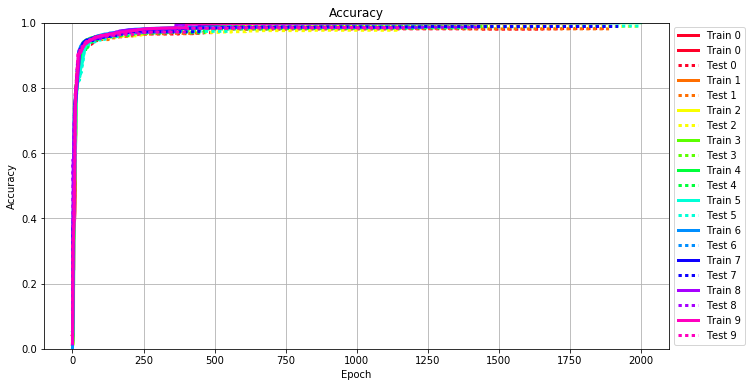

In [51]:
plot_acc(history)

In [46]:
def plot_loss(history):
    figure = plt.gcf()
    figure.set_size_inches(14, 6)
    ax = plt.subplot()
    plt.title('Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    colors = iter(colormap.gist_rainbow(np.linspace(0, 1, len(history))))
    for i in range(len(history)):
        color=next(colors)
        plt.plot(history[i].history['loss'], label='Train '+str(i), color=color, linestyle = 'solid', linewidth=3.0)
        plt.plot(history[i].history['val_loss'], label='Test '+str(i), color=color, linestyle = 'dotted', linewidth=3.0)
    plt.legend()
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True)
    plt.show()

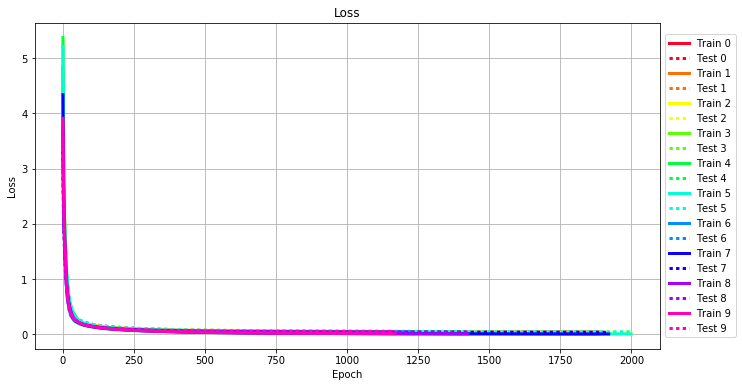

In [47]:
plot_loss(history)

Plotting the confusion matrix


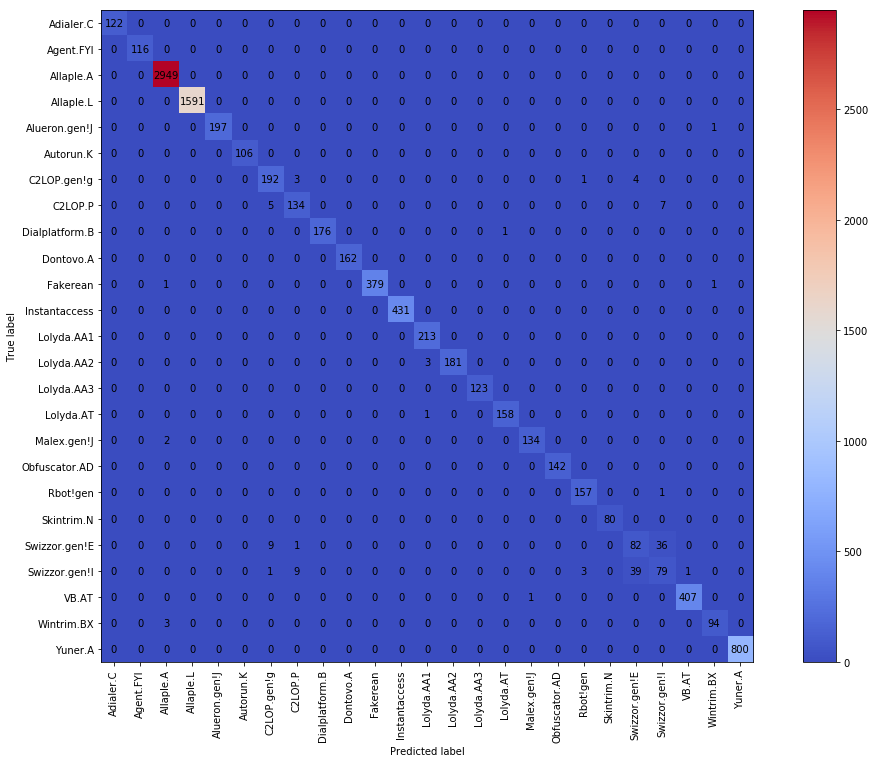

In [16]:
print("Plotting the confusion matrix")
figure = plt.gcf()
figure.set_size_inches(18, 12)
plt.imshow(conf_mat,interpolation='nearest',cmap='coolwarm')
for row in range(len(list_fams)):
    for col in range(len(list_fams)):
        plt.annotate(str(int(conf_mat[row][col])),xy=(col,row),ha='center',va='center')
plt.xticks(range(len(list_fams)),list_fams,rotation=90,fontsize=10)
plt.yticks(range(len(list_fams)),list_fams,fontsize=10)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.colorbar()
plt.show()

Plotting the confusion matrix normalized


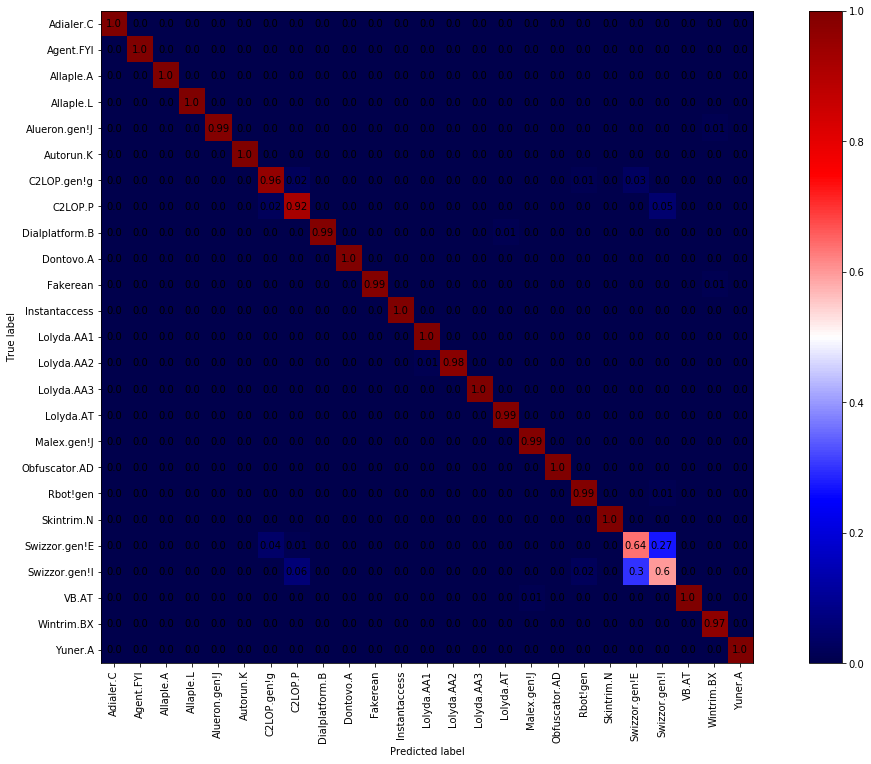

In [17]:
print("Plotting the confusion matrix normalized")
conf_mat_norm = conf_mat/no_imgs  # Normalizing the confusion matrix
conf_mat_norm = np.around(conf_mat_norm,decimals=2)  # rounding to display in figure
figure = plt.gcf()
figure.set_size_inches(20, 12)
plt.imshow(conf_mat_norm,interpolation='nearest',cmap='seismic')
for row in range(len(list_fams)):
    for col in range(len(list_fams)):
        plt.annotate(str(conf_mat_norm[row][col]),xy=(col,row),ha='center',va='center')
plt.xticks(range(len(list_fams)),list_fams,rotation=90,fontsize=10)
plt.yticks(range(len(list_fams)),list_fams,fontsize=10)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.colorbar()
plt.show()

Plotting the confusion matrix normalized


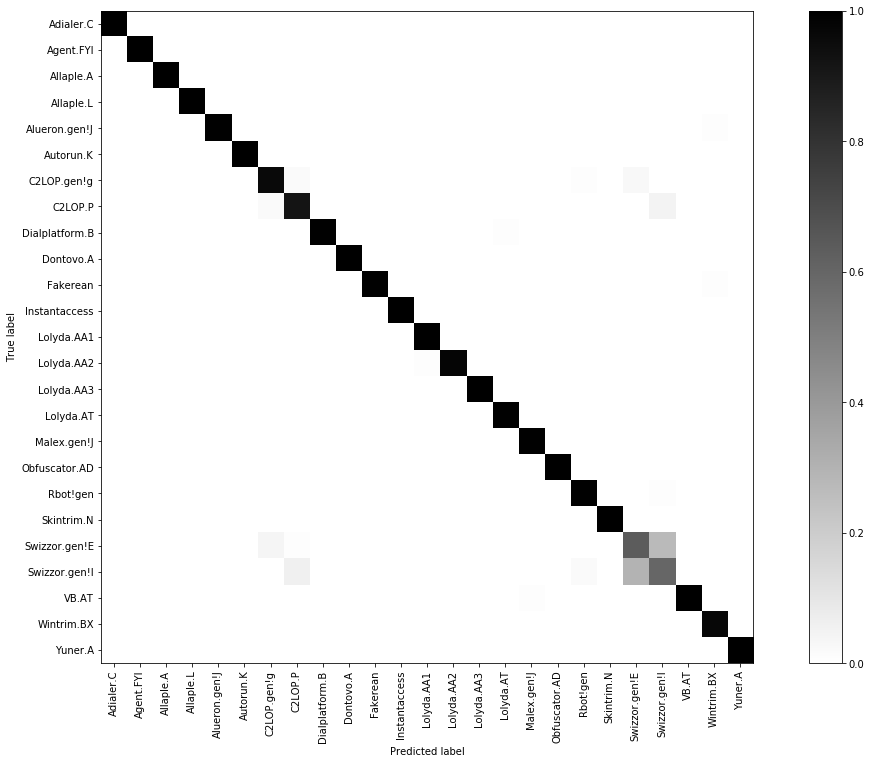

In [18]:
print("Plotting the confusion matrix normalized")
conf_mat_norm = conf_mat/no_imgs  # Normalizing the confusion matrix
conf_mat_norm = np.around(conf_mat_norm,decimals=2)  # rounding to display in figure
figure = plt.gcf()
figure.set_size_inches(20, 12)
plt.imshow(conf_mat_norm,interpolation='nearest',cmap='binary')
plt.xticks(range(len(list_fams)),list_fams,rotation=90,fontsize=10)
plt.yticks(range(len(list_fams)),list_fams,fontsize=10)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.colorbar()
plt.show()